<div style="text-align: center;">
  <h1 style="margin: 0">Concurso de modelización de empresas</h1>
  <h2 style="margin: 0">Management Solutions</h2>
  <h3 style="margin-top: 5px">Enrique Queipo de Llano, Alejandro Paz Olalla, Marius Ciurcau</h3>
</div>


Solución para el problema de modelización de empresas propuesto por Management Solutions en la
Facultad de Matemáticas UCM en el curso 2023-2024. La solución ha sido desarrollada po el grupo Barquitos, compuesto por
Marius Ciurcau, Alejandro Paz y Enrique Queipo de Llano, estudiantes del Doble Grado de Matemáticas e Ingeniería Informática. Este notebook es una guía paso a paso por nuestra solución.

**Índice**
<!-- TOC -->
- [1. Exploración y preprocesado de los datos](#1)
- [2. Sentiment Analysis con Mistral](#2)
- [3. Decision Tree](#3)
    - [3.1. Análisis de la variable `Rating`](#3-1)
    - [3.2. Entrenamiento y evaluación sin oversampling](#3-2)
    - [3.3. Entrenamiento y evaluación con oversampling](#3-3)
    - [3.4. Regresión](#3-4)
- [4. Conclusiones](#4)
- [5. Anexo. Pruebas con `GridSearchCV`](#5)
    - [5.1. `GridSearchCV` para el árbol de clasificación](#5-1)
    - [5.2. `GridSearchCV` para el árbol de regresión](#5-2)
<!-- /TOC -->

Contamos con un archivo `dfSentiment.pkl` con el DataFrame con las reviews ya clasificadas por el LLM ejecutado por nosotros mismos. Se puede saltar a la sección 3 directamente donde se carga el DataFrame con las reviews ya clasificadas desde ese mismo archivo.

In [ ]:
# Ejecutar para instalar dependencias
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from langchain.llms import CTransformers
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
sns.set()

In [3]:
RANDOM_STATE = 123 # seed

<a id='1'></a>
## 1. Exploración y preprocesado de los datos 

En esta sección se cargan los datos a partir del CSV y se realiza un proprocesado de los datos que nos facilitará el trabajo de clasificación y que se explica en las siguientes celdas.  
Comenzamos cargando los datos en la variable df que representará el DataFrame con el que trabajaremos. Nos quedamos con las columnas
`Review`, `Metadata` y `Rating` en el DataFrame puesto que estas son las relevantes para nuestro estudio e imprimimos las primeras cinco entradas para ver la apariencia de nuestro conjunto de datos.

In [3]:
df = pd.read_csv('Restaurant_reviews.csv')
columns_to_keep = ['Review', 'Metadata', 'Rating']
df = df[columns_to_keep]
df.head()

Review                 Metadata  \
0  The ambience was good, food was quite good . h...   1 Review , 2 Followers   
1  Ambience is too good for a pleasant evening. S...  3 Reviews , 2 Followers   
2  A must try.. great food great ambience. Thnx f...  2 Reviews , 3 Followers   
3  Soumen das and Arun was a great guy. Only beca...    1 Review , 1 Follower   
4  Food is good.we ordered Kodi drumsticks and ba...  3 Reviews , 2 Followers   

  Rating  
0      5  
1      5  
2      5  
3      5  
4      5

Comenzamos ejecutando `df.info()` para ver de que tipo son los valores de las columnas de nuestro DataFrame y cuántas entradas son no nulas. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    9955 non-null   object
 1   Metadata  9962 non-null   object
 2   Rating    9962 non-null   object
dtypes: object(3)
memory usage: 234.5+ KB


Observamos que el DataFrame tiene 10.000 entradas pero  en la columna `Review`, tan solo 9955 de ellas tienen valores no nulos.En la siguiente celda comprobamos que efectivamente 45 entradas tienen valor nulo y, puesto que no tiene sentido clasificar una review nula, procedemos a la eliminación de estas filas.

In [5]:
df['Review'].isnull().sum()

45

En el DataFrame en el que se han cargado los datos, eliminamos las filas con valor nulo para el campo `Review` y comprobamos mediante `df.info()` que ahora contamos con 9955 entradas (las 10000 iniciales eliminando las 45 que tenían review nula), todas de ellas con datos no nulos.

In [6]:
df = df.dropna(subset=['Review'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9955 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    9955 non-null   object
 1   Metadata  9955 non-null   object
 2   Rating    9955 non-null   object
dtypes: object(3)
memory usage: 311.1+ KB



Una vez eliminados los datos nulos del DataFrame, nos centramos en la columna `Metadata`. Como hemos visto al principio, esta celda contiene el número de followers y de reviews separados con una coma con las que cuenta el usuario que ha escrito la review que aparece en el DataFrame. Procedemos a separar entonces la columna `Metadata` en dos columnas (`NumReviews` y `Followers`) para tener acceso independiente a estos dos campos en todo momento. Para esto usamos la expresión regular que se reconoce en los valores de la columna `Metadata` y posteriormente borramos esta columna, pues ya no nos interesa.

In [7]:
#Utilizamos este patron para buscar dos numeros (sin tener en cuenta cualquier texto que aparezca antes, en medio o despues de estos)
#en los valores que toma Metadata
pattern = r'(\d+).*?(\d+)'

# Mediante str.extract() y el patron anterior se crean las dos nuevas columnas en las que estamos interesados a partir de Metadata. 
# Activamos el flag expand = True para que cree una columna por cada número detectado
df[['NumReviews', 'Followers']] = df['Metadata'].str.extract(pattern, expand=True)

# Establecemos el tipo de las dos columnas resultantes como int (pues ahora solo contienen números enteros) y rellenamos con ceros los datos que 
# no venían especificados en Metadata (pues entendemos que si no vienen especificados es porque valen 0)
df['NumReviews'] = pd.to_numeric(df['NumReviews']).fillna(0).astype(int)
df['Followers'] = pd.to_numeric(df['Followers']).fillna(0).astype(int)
df.head()

Review                 Metadata  \
0  The ambience was good, food was quite good . h...   1 Review , 2 Followers   
1  Ambience is too good for a pleasant evening. S...  3 Reviews , 2 Followers   
2  A must try.. great food great ambience. Thnx f...  2 Reviews , 3 Followers   
3  Soumen das and Arun was a great guy. Only beca...    1 Review , 1 Follower   
4  Food is good.we ordered Kodi drumsticks and ba...  3 Reviews , 2 Followers   

  Rating  NumReviews  Followers  
0      5           1          2  
1      5           3          2  
2      5           2          3  
3      5           1          1  
4      5           3          2

Una vez creadas las dos nuevas columnas, procedemos a eliminar `Metadata` y comprobamos que aparecen en su lugar `NumReviews` y `Followers`, que son de tipo entero y que tenemos 9955 valores, todos no nulos. Además, reordenamos las columnas.

In [8]:
#axis = 1 porque queremos eliminar una columna, inplace = True para realizar la operación sobre el propio DataFrame y que no se devuelva una copia
df.drop('Metadata', axis=1, inplace=True)
df = df[['Review', 'NumReviews', 'Followers', 'Rating']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9955 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      9955 non-null   object
 1   NumReviews  9955 non-null   int64 
 2   Followers   9955 non-null   int64 
 3   Rating      9955 non-null   object
dtypes: int64(2), object(2)
memory usage: 388.9+ KB


Ya hemos analizado la columna `Review` eliminando las entradas nulas que no interesan y hemos descartado la columna `Metadata` tras crear a partir de ella dos nuevas columnas que contienen la misma información pero mejor presentada.

<a id='2'></a>
## 2. Sentiment Analysis con Mistral

Para realizar el sentiment analysis sobre las reviews del DataFrame hemos escogido el modelo de lenguaje Mistral, más concretamente la versión Mistral-Instruct, que ha sido específicamente ajustada para realizar tareas específicas a partir de instrucciones. Nos hemos decantado por Mistral debido al rendimiento superior que este modelo de 7 billones de parámetros muestra en comparación con otros modelos de tamaño similar. También es superior a versiones de 13 billones de parámetros de algunos modelos, incluido Llama-2. Para más información, véase la sección 4 del siguiente documento: [https://arxiv.org/pdf/2310.06825.pdf](https://arxiv.org/pdf/2310.06825.pdf)

Hemos seleccionado la versión GGUF del modelo, que puede encontrarse en [Hugging Face](https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF), más concretamente la versión cuantificada `Q5_K_M`, que reduce los requisitos de memoria para cargar el modelo con bajas pérdidas en la calidad de la inferencia.

In [ ]:
config = {'context_length': 2000, 'seed': 123}
llm = CTransformers(model="TheBloke/Mistral-7B-Instruct-v0.1-GGUF", model_file="mistral-7b-instruct-v0.1.Q5_K_M.gguf", config=config, model_type='llama')

La siguiente función emplea expresiones regulares para extraer el valor de `Sentiment` a partir del texto generado por Mistral.

In [9]:
def find_sentiment(text):
    pattern = r'\b(positive|negative|neutral)\b'
    match = re.search(pattern, text, re.I) # re.I ignora mayusculas
    if match:
        return match.group(0).capitalize()
    return None

En las dos siguientes celdas se utiliza el modelo de lenguaje Mistral para completar la columna `Sentiment` del DataFrame clasificando las reviews de una en una.

Debido al tiempo que conlleva clasificar el DataFrame completo, el código está estructurado de forma de manera que sea posible clasificarlo por partes, es decir, estableciendo un número de reviews a clasificar en cada ejecución y guardando el DataFrame en un archivo `.pkl` de forma periódica, en este caso cada 50 reviews.

Estableciendo el valor de `load_df` a `True` en la siguiente celda, se lee el DataFrame del archivo `dfSentiment.pkl` y se inicia la clasificación desde la primera review no clasificada, es decir, con `Sentiment` nulo.  Con dicho valor a `False`, se procedería a clasificar el DataFrame completo.

El prompt del modelo sigue el formato especificado en HuggingFace, pues es necesario añadir las directivas `[INST]` y `[/INST]` para ajustarse al formato que se ha utilizado para ajustar Mistral-7B-v0.1 y obtener Mistral-7B-Instruct-v0.1.

In [29]:
load_df = True # False si se desea replicar el proceso completo de clasificación
start_idx = 0
if load_df:
    df = pd.read_pickle("./dfSentiment.pkl")
    nulos = df[df['Sentiment'].isna()].index
    if len(nulos) == 0: # si no hay valores nulos significa que ya se ha clasificado el dataframe completo y establecemos el punto de inicio en el final del dataframe para omitir el proceso
        start_idx = df.index[-1] + 1
    else:
        start_idx = df[df['Sentiment'].isna()].index[0] # tomamos como punto de inicio el primer índice no clasificado
else:
    df['Sentiment'] = [None for _ in range(len(df['Reviews']))] # creamos la columna Sentiment y la rellenamos con el valor nulo

if start_idx > df.index[-1]:
    print("No hay ningún valor nulo en la columna Sentiment")
if start_idx <= df.index[-1]:
    print(f"""El primer índice nulo es {start_idx}""")

No hay ningún valor nulo en la columna Sentiment


La clasificación completa de las reviews ha requerido alrededor de unas 10 horas en un equipo con un procesador Intel Core i7-13700K @ 5.40GHz y memoria RAM 2x16GB DDR5 5600MHz. El notebook no está configurado para hacer uso de una GPU, ya que no contábamos con una unidad de procesamiento gráfico compatible para este tipo de tareas. **Por tanto, no es recomendable ejecutar la siguiente celda. En su lugar, recomendamos cargar el DataFrame estableciendo el valor de `load_df` a `True` en la celda anterior.**

In [30]:
batch_size = 1000
classified = 0
reviews = df['Review']

if start_idx > df.index[-1]:
    print("Las reviews ya están clasificadas")
else:
    print(f"""Clasificando desde el índice {start_idx} hasta el índice {min(start_idx+batch_size, df.index[-1])}""")

template = """<s>[INST]{question}[/INST]"""
prompt = PromptTemplate(template=template, input_variables=["question"],)
llm_chain = LLMChain(prompt=prompt, llm=llm)

for i, row in df.iloc[start_idx:].iterrows():
    review = row['Review']
    response = llm_chain.run(f""""Please classify the following review as either Positive, Negative, or Neutral. Under any circumstances, answer only one of these words. Here is the review: {review}""")
    df.at[i, 'Sentiment'] = find_sentiment(response)
    print(i, response)
    print(review)
    if i > 0 and i%50 == 0:
        df.to_pickle("./dfSentiment.pkl") # guardado automatico cada 50 reviews
    classified += 1
    if classified == batch_size:
        break

Las reviews ya están clasificadas


Guardamos el DataFrame en un archivo `.pkl` al concluir la clasificación.

In [10]:
df.to_pickle("./dfSentiment.pkl")

**No es necesario ejecutar las siguientes celdas de esta sección. Su propósito es documentar el proceso por el que hemos completado la clasificación anterior.**


En la siguiente celda vemos que, a pesar de que el modelo ha hecho un buen trabajo clasificando las reviews, existen algunas que no ha sido capaz de clasificar correctamente, por lo que el valor de `Sentiment` sigue siendo nulo.

In [33]:
# NO EJECUTAR
not_classified = df[df['Sentiment'].isnull()].index
not_classified

Int64Index([ 970, 1591, 1592, 2350, 2389, 2996, 3351, 3559, 3594, 3743, 3758,
            3759, 4004, 4155, 4555, 4771, 4789, 4829, 4892, 6105, 6106, 6266,
            6282, 6298, 6365, 6416, 6417, 6446, 6677, 7360, 7497, 7539, 7568,
            7673, 7674, 7675, 7676, 7769, 7771, 7774, 7969, 7992, 8129, 8136,
            8166, 8247, 8255, 8276, 8588, 8856, 8873, 8879, 8883, 8948, 9597],
           dtype='int64')

Para tratar de corregir esto, volvemos a pedirle al modelo que clasifique estas reviews, pero en esta ocasión con un prompt modificado que hace especial énfasis en que la respuesta sea una única palabra y esta sea alguna de las palabras válidas.

In [34]:
# NO EJECUTAR
template = """<s>[INST]{question}[/INST]"""
prompt = PromptTemplate(template=template, input_variables=["question"],)
llm_chain = LLMChain(prompt=prompt, llm=llm)

for idx in not_classified:
    review = df.at[idx, 'Review']
    response = llm_chain.run(f""""Please classify the following reviews as either "Positive", "Negative", or "Neutral", using only one word. Any other word is not valid. Here is the review: {review}""")
    df.at[idx, 'Sentiment'] = find_sentiment(response)
    print(idx, response)
    print(review)

970  Fantastic
ordered nuts overloaded ice cream.fantastic taste.
1591  Positive
nice
1592  Positive
nice
2350  Positive
nice
2389  Positive
nice
2996  Neutral
Before the time
3351  Negative
Staff was very rude. Confused the order and asked our group to leave. Worst service staff I've seen so far in Hyderabad. STRICTLY DO NOT RECOMMEND.
3559  Positive
nice
3594  Negative
cc
3743  Without seeing the review, I cannot provide a classification. Please provide the review so that I can assist you.
o
3758  Neutral
Nice delivery boy good communication,Super
3759  Positive
nice
4004  Positive.
Best food I have ever had..Satisfied with every dish and there are so yummy. We tried club chilly cheese toast,mezze platter,florenten garden,spicy tomato arabiatta,signature mushroom risoto and
frio's signature tiramasu..Every thing is great and unique....It is not the place for spicy lovers....U should visit this place to taste unique and delicious food...Love the ambience too
4155  Positive
nice
4555  

Observamos que ahora ha hecho un mejor trabajo, pero sigue habiendo 6 reviews no clasificadas. Como es una cantidad muy pequeña, hemos optado por descartar estas reviews. 

In [35]:
# NO EJECUTAR
df[df['Sentiment'].isnull()].index

Int64Index([970, 3743, 6677, 8166, 8255, 9597], dtype='int64')

In [38]:
# NO EJECUTAR
df = df.dropna(subset=['Sentiment'])

Comprobamos que ningún valor de la columna `Sentiment` es nulo:

In [39]:
# NO EJECUTAR
df['Sentiment'].isnull().sum()

0

Por último, guardamos el DataFrame final en un archivo `.pkl`.

In [40]:
# NO EJECUTAR
df.to_pickle("./dfSentiment.pkl")

<a id='3'></a>
## 3. Decision Tree

En esta sección comenzamos analizando y preprocesando la columna `Rating` para quedar el problema de predicción de este valor para una review preparado como problema de clasificación. Como se explicará posteriormente, al ver los valores que aparecen en esta columna se podrán plantear diferentes maneras de abordar el problema. Analizaremos las ventajas y desventajas de cada una de ellas para escoger la que mejor debería funcionar en base a los datos que tenemos. Para toda la sección, utilizaremos el DataFrame `dfSentiment.pkl`, en el cual tenemos ya la columna `Sentiment` producida por Mistral.

<a id='3-1'></a>
### 3.1. Analisis de la variable `Rating`

En esta subsección, haremos un poco de preprocesado y visualización de la variable a predecir `Rating`.

In [4]:
df = pd.read_pickle("./dfSentiment.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9949 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      9949 non-null   object
 1   NumReviews  9949 non-null   int32 
 2   Followers   9949 non-null   int32 
 3   Sentiment   9949 non-null   object
 4   Rating      9949 non-null   object
dtypes: int32(2), object(3)
memory usage: 388.6+ KB


A continuación, exploremos la columna `Rating` mediante la función `unique()` para ver que valores aparecen en dicha columna.

In [5]:
df['Rating'].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like'],
      dtype=object)

Para nuestra sorpresa, observamos que esta columna toma valores tanto de tipo `int` como de tipo `float` y esto puede ser tema de discusión a la hora de predecir el valor de `Rating`, pues ahora se puede afrontar desde varias perspectivas este problemas. Algunas de las opciones que consideramos más relevantes son: 

- Comprobar cuantos valores decimales aparecen y en caso de ser una cantidad despreciable, prescindir de ellos o ajustarlos a un número entero entre 1 y 5. Esto nos permitirá trabajar con un problema de clasificación en 5 clases. 

- En el caso de que la cantidad de valores decimales que aparecen no sea desprecibale, una opción es afrontar el problema como un un problema de clasificación en 9 clases, dando una clase a cada valor (ya sea entero o decimal) que encontramos en la columna `Rating`.

- Afrontar el problema como un problema de regresión, es decir, entender que el campo `Rating` de una review puede tomar cualquier valor continuo en el intervalo [1,5] en lugar de solo ciertos valores discretos.

Observamos que también aparece el valor `Like` en algunas filas. Procederemos en las celdas siguientes a comprobar la relevancia de dicho valor.

Comprobamos primero que no tenemos valores nulos en `Rating` que podrían entorpecer el análisis posterior.

In [6]:
df['Rating'].isna().sum()

0

Procedemos a continuación a ejecutar `df['Rating'].value_counts()` para ver cuántas entradas exactamente toman cada uno de los valores que aparecen en la columna `Rating` y así tomar una decisión justificada en lo que se refiere al modo de afrontar el problema. 

In [7]:
df['Rating'].value_counts()

5       3822
4       2373
1       1734
3       1191
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

Como tan solo hay una entrada que tome el valor `Like` en la columna `Rating`, eliminamos dicha columna. También podría reemplazarse por un 3,4 o 5.

Por otro lado, observamos que tan solo hay 144 entradas que toman valores decimales en esta columna, lo cual parece indicar que puede ser correcto ajustar estos valores para que pasen a ser enteros, pues 144 se puede considerar despreciable con respecto a 9948.  

Decidimos entonces redondear los valores no enteros de `Rating` a su parte entera, pues consideramos que de esta manera se pierde muy poca información y el problema queda mucho mejor definido:  un problema de clasificación en cinco clases.  

Además, dado que aparecen muy pocos valores decimales, no nos parece correcto plantearlo como clasificación con los valores 1.5, 2.5, 3.5 y 4.5, pues no tendríamos suficientes ejemplos para poder clasificar correctamente.  

Otro hecho que justifica el redondeo hacia abajo de los valores decimales es que, a simple vista, se percibe que aparecen muchas más puntuaciones positivas que negativas, por tanto, esta acción pueda favorecer el equilibrio de clases en los datos de entrenamiento (si decidieramos clasificar en 9 clases o redondear hacia arriba, este desequilibrio sería todavía mayor).

Procedemos entonces a efectuar los cambios mencionados en el párrafo anterior a nuestro DataFrame.  Además, de este modo, al pasar del decimal al entero, se redondea el número a su parte entera automáticamente. 

Ejecutamos `df.info()` para asegurarnos de que los cambios se han realizado correctamente.

In [8]:
#Eliminamos las entradas que tengan Raiting = like
df = df[df['Rating'] != 'Like']
#Cambiamos el tipo de la columnaRatingg primero a float y luego a int
df['Rating'] = df['Rating'].astype(float).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9948 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      9948 non-null   object
 1   NumReviews  9948 non-null   int32 
 2   Followers   9948 non-null   int32 
 3   Sentiment   9948 non-null   object
 4   Rating      9948 non-null   int64 
dtypes: int32(2), int64(1), object(2)
memory usage: 388.6+ KB


Una vez comprobado que el DataFrame tiene exactamente el formato deseado, ejecutamos de nuevo `value_counts()` sobre la columna `Rating` para analizar el equilibrio de las clases en las que queremos clasificar.

In [9]:
df['Rating'].value_counts()

5    3822
4    2442
1    1743
3    1238
2     703
Name: Rating, dtype: int64

Se observa que contamos con muchas más reviews con puntuación de 4 o 5 que el resto (el ~60% son de este tipo), lo cual nos podría suponer luego un problema. Para ver este hecho de manera más clara, graficamos el número de ejemplos que tenemos de cada clase. 

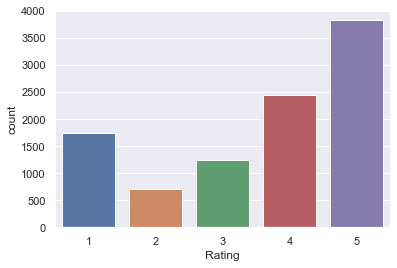

In [16]:
sns.countplot(x='Rating', data=df)
plt.show()

Efectivamente, nuestras sospechas sobre el desequilibrio de clases en el conjunto de datos de entrenamiento son ciertas. Esto nos hace pensar que puede ser bueno realizar todo el trabajo de clasificación que se presenta posteriormente con un conjunto de datos modificado con ayuda del algoritmo SMOTE (Synthetic Minority Oversampling Technique) de la librería `imblearn` para ajustar el número de ejemplos por clase. Después será interesante comparar los árboles de decisión obtenidos al entrenar cada uno de los conjuntos.

Tras analizar y preprocesar los datos con los que tenemos que trabajar, hemos tomado la siguiente decisión: Afrontaremos el problema como un problema de clasificación en 5 clases (los enteros del 1 al 5) y entrenaremos el árbol de decisión con el conjunto de datos original así como con un conjunto de datos modificado con SMOTE a partir del original con el fin de ver si el hecho de tener muchos más ejemplos con Ratings positivos es decisivo a la hora de entrenar el árbol. 

Posteriormente, se afrontará el problema como un problema de regresión para comparar resultados y analizar si realmente hemos tomado la mejor decisión. 

En la siguiente celda, dibujamos mediante una gráfica 3D interactiva los datos con los que contamos para hacernos una idea de como se distribuirían en el espacio. En el eje X se muestra el número de reviews del usuario, en el Y el número de seguidores, en
el eje Z se puede ver el `Rating` de la review y los colores muestran cómo la ha clasificado
el LLM.

In [10]:
fig = px.scatter_3d(df, x='NumReviews', y='Followers', z='Rating', color='Sentiment')
fig.update_traces(marker_size=4)
fig.show()

Observamos que la clasificación del LLM Mistral es coherente con los datos por lo general. Las reviews negativas (en verde) son, en su mayoría, las que han recibido una puntuación de 1 o 2. De igual modo las positivas (en azul) son las que por lo general han recibido un 4 o 5. Las reviews clasificadas con Neutral (en rojo) están entre el 3 y el 4.

LLegados a este punto cabe destacar que todo apunta a que nos enfrentamos a un problema realmente difícil, pues tan solo contamos con 3 variables y a priori solo una de ellas es verdaramente relevante. Para ratificar esta afirmación basta observar con cierto detenimiento el gráfico de arriba: tan solo se aprecia un patrón de comportamiento que relaciona `Rating` y `Sentiment`, para el resto de variables que se utilizan a la hora de predecir, se aprecia mucho desorden en cuanto a la relación que guardan con el valor de `Rating` (comprobaremos que esto es cierto posteriormente al analizar la importancia que tiene cada variable en cuanto a la decisión que toma el árbol). 
Por otro lado, esto hace que no contemos con herramientas para distinguir entre los valores 4/5 y 1/2 en la columna `Rating`, esto es, si la columna `Sentiment` tiene valor positivo para una review, es muy probable que tenga se tenga que predecir un valor mayor que 3 para `Rating`, pero el resto de variables no nos ayudan a decidirnos entre 3, 4 o 5 (y lo mismo pasa con las reviews negativas). Esto nos lleva a concluir lo siguiente:

- A la hora de afrontar el problema como un problema de clasificación, debemos conformarnos a priori con que no haya mucha confusión entre ratings mayores que 3 y menores que 3, pues esto no representa un error grave (realmente, se distingue entre rating bajas y altas aunque no se afine en cómo de positiva o negativa es la review) como si que lo sería por ejemplo asignar a una review positiva un valor de rating menor que 3. Evidentemente, esta importancia de unos errores frente a otros no son distinguibles al calcular métricas como precisión y recall, por tanto, debemos apoyarnos en todo momento en la matriz de confusión a la hora de evaluar el comportamiento del árbol. 

- A la hora de afrontar el problema como un problema de regresión, debemos tener en cuenta que hemos eliminado los valores decimales (eran tan solo 144, una cantidad despreciable) y por tanto métricas del tipo del error cuadrático siempre serán realmente altas. Esto ocurre porque se predecirán valores decimales que se compararán únicamente con valores enteros a la hora de calcular las métricas. Esto, tampoco debe preocuparnos mucho, siempre y cuando se observe que los valores predichos están razonablemente cerca (rating real +-1) de los reales, pues al predecir 4,2 en una review con un rating de 4, se produce un error considerable si somos estrictos, pero este error no es realmente importante.

A continuación, para entrenar los árboles de decisión con sklearn necesitamos codificar nuestra variable categórica `Sentiment`.

In [12]:
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}

# Usamos la funcion para codificar el Sentiment
df['Sentiment_encoded'] = df['Sentiment'].map(sentiment_mapping)
df.head()

Review  NumReviews  Followers  \
0  The ambience was good, food was quite good . h...           1          2   
1  Ambience is too good for a pleasant evening. S...           3          2   
2  A must try.. great food great ambience. Thnx f...           2          3   
3  Soumen das and Arun was a great guy. Only beca...           1          1   
4  Food is good.we ordered Kodi drumsticks and ba...           3          2   

  Sentiment  Rating  Sentiment_encoded  
0  Positive       5                  1  
1  Positive       5                  1  
2  Positive       5                  1  
3  Positive       5                  1  
4  Positive       5                  1

Guardamos en `X` las variables predictoras y en `y` la variable a predecir.

In [43]:
X = df[['Sentiment_encoded', 'Followers', 'NumReviews']]
y = df['Rating']

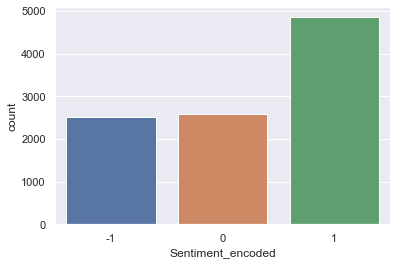

In [20]:
sns.countplot(x = 'Sentiment_encoded', data = X)
plt.show()

Observamos que tenemos muchas más reviews clasificadas como `Positive` que como `Negative` o `Neutral`. Esto es coherente con lo que comentábamos anteriormente, dado que veíamos que había más cuatros y cincos que los demás, lo cual justifica que probemos también con oversampling.

<a id='3-2'></a>
### 3.2. Entrenamiento y evaluación sin oversampling

Comenzamos separando el conjunto de datos en train y test. Usaremos un 80% de los datos para entrenar y el resto para testear. Ajustamos el `random_state` para permitir la reproducibilidad de todo el proceso. 

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

Hacemos una búsqueda de la mejor profundidad máxima. Obtenemos las puntuaciones para cada una de ellas y las dibujamos en una gráfica de tal modo que se observen las precisiones en train y en test. 

In [22]:
train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 8)
for md in max_depths: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, random_state=RANDOM_STATE)
    scores = cross_validate(clf, X.values, y.values, scoring='accuracy', cv=10, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
train_accuracy, test_accuracy

([0.5442299973147937,
  0.595798190989747,
  0.600991834832193,
  0.6241791091247342,
  0.6254300789662223,
  0.6308359534033,
  0.6357392204858265],
 [0.5442301042435519,
  0.5958014418167296,
  0.5983140046308,
  0.6177158427954662,
  0.6163085042920841,
  0.6178163453080291,
  0.6149004580245291])

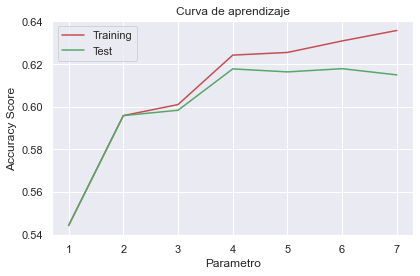

In [23]:
# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()  

A la vista de la gráfica, se observa que la precisión mejora significativamente al pasar de profundidad 3 a 4. Para profunidades mayores, aunque mejora en Training disminuye en Test, lo cual puede indicar overfitting. Por esto, vamos a probar el modelo con `max_depth = 4`. Vamos a obtener la puntuación para distintas métricas utilizando cross-validation y posteriormente, probaremos a hacer un train_test_split para dibujar una matriz de confusión.

In [25]:
# Escribimos las métricas que queremos evaluar
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']

# Construimos el clasificador
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=2, random_state=RANDOM_STATE)

# Calculamos las métricas utilizando validación cruzada
scores = cross_validate(clf, X, y, scoring=scoring_metrics, cv=10, return_train_score=False)

# Mostrar las métricas agregadas
print('Precisión ponderada media: ', np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media: ', np.mean(scores['test_recall_weighted']))
print('F1 ponderado media: ', np.mean(scores['test_f1_weighted']))

/Users/quiquequeipodellano/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/quiquequeipodellano/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/quiquequeipodellano/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/quiquequeipodellano/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no pred

Precisión ponderada media:  0.52947949820639
Exhaustividad ponderada media:  0.6177158427954662
F1 ponderado media:  0.5641104214546121


/Users/quiquequeipodellano/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Nuestro modelo obtiene:
- Precisión ponderada media de 52.94%
- Exhaustividad ponderada media de 61.77%
- F1 ponderado medio de 56.11%

Hacemos uso de la siguiente función de la librería scikit-learn que utilizaremos para presentar la matriz de confusión de manera que su análisis resulte intuitivo.

In [26]:
# Función extraída de
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Calculamos las métricas relevantes y la matriz de confusión según el `train_test_split`

Accuracy: 60.90%
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.83      0.76       355
           2       0.24      0.10      0.14       126
           3       0.22      0.03      0.06       249
           4       0.46      0.61      0.52       484
           5       0.71      0.78      0.74       776

    accuracy                           0.61      1990
   macro avg       0.47      0.47      0.44      1990
weighted avg       0.56      0.61      0.57      1990

Confusion matrix, without normalization
[[293  20  17   9  16]
 [ 69  12  10  20  15]
 [ 39  14   8 147  41]
 [  9   3   1 294 177]
 [  3   0   0 168 605]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

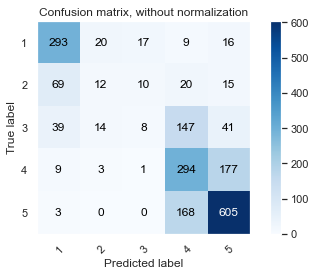

In [27]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=2, random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

# Precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Análisis de clasificación
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Matriz de confusión
classes = np.sort(y_test.unique())
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(y_test, y_pred, classes)

Observamos que no hay sorpresa en los resultados obtenidos en las métricas de evaluación con respecto a lo que hemos comentado anteriormente. A simple vista, se obtien valores bastante malos para la precisión, el recall y la puntuación f1, sin embargo, si a la hora de analizar nos fijamos también en la matriz de confusión vemos que no lo ha hecho tan mal. Prácticamente todas las confusiones entre clases que aparecen se resumen en confundir la clase 1 con la 2 y la clase 4 con la 5 (aunque distingue mejor las clases del 1 y el 2 entre ellas, probablemente porque estas clases son las menos ejemplificadas). Se observa también que la clase del 3 aparece un poco difusa, lo cual no debe preocuparnos, pues al encontrarse este valor en el centro del intervalo de clasificación, puede ser viable confundir el 3 tanto con el 2 como con el 4 (una review que da puntuación 3 puede haber sido clasificada por Mistral como neutra, positiva o negativa indistintamente). 

En definitiva, concluimos que a pesar de no obtener muy buenos resultados en lo que a las métricas clásicas se refiere, el árbol funciona bien y es capaz de distinguir las clases importantes entre ellas. De nuevo, sería más preocupante si confundiera la clase del 4 con el 1, por ejemplo.

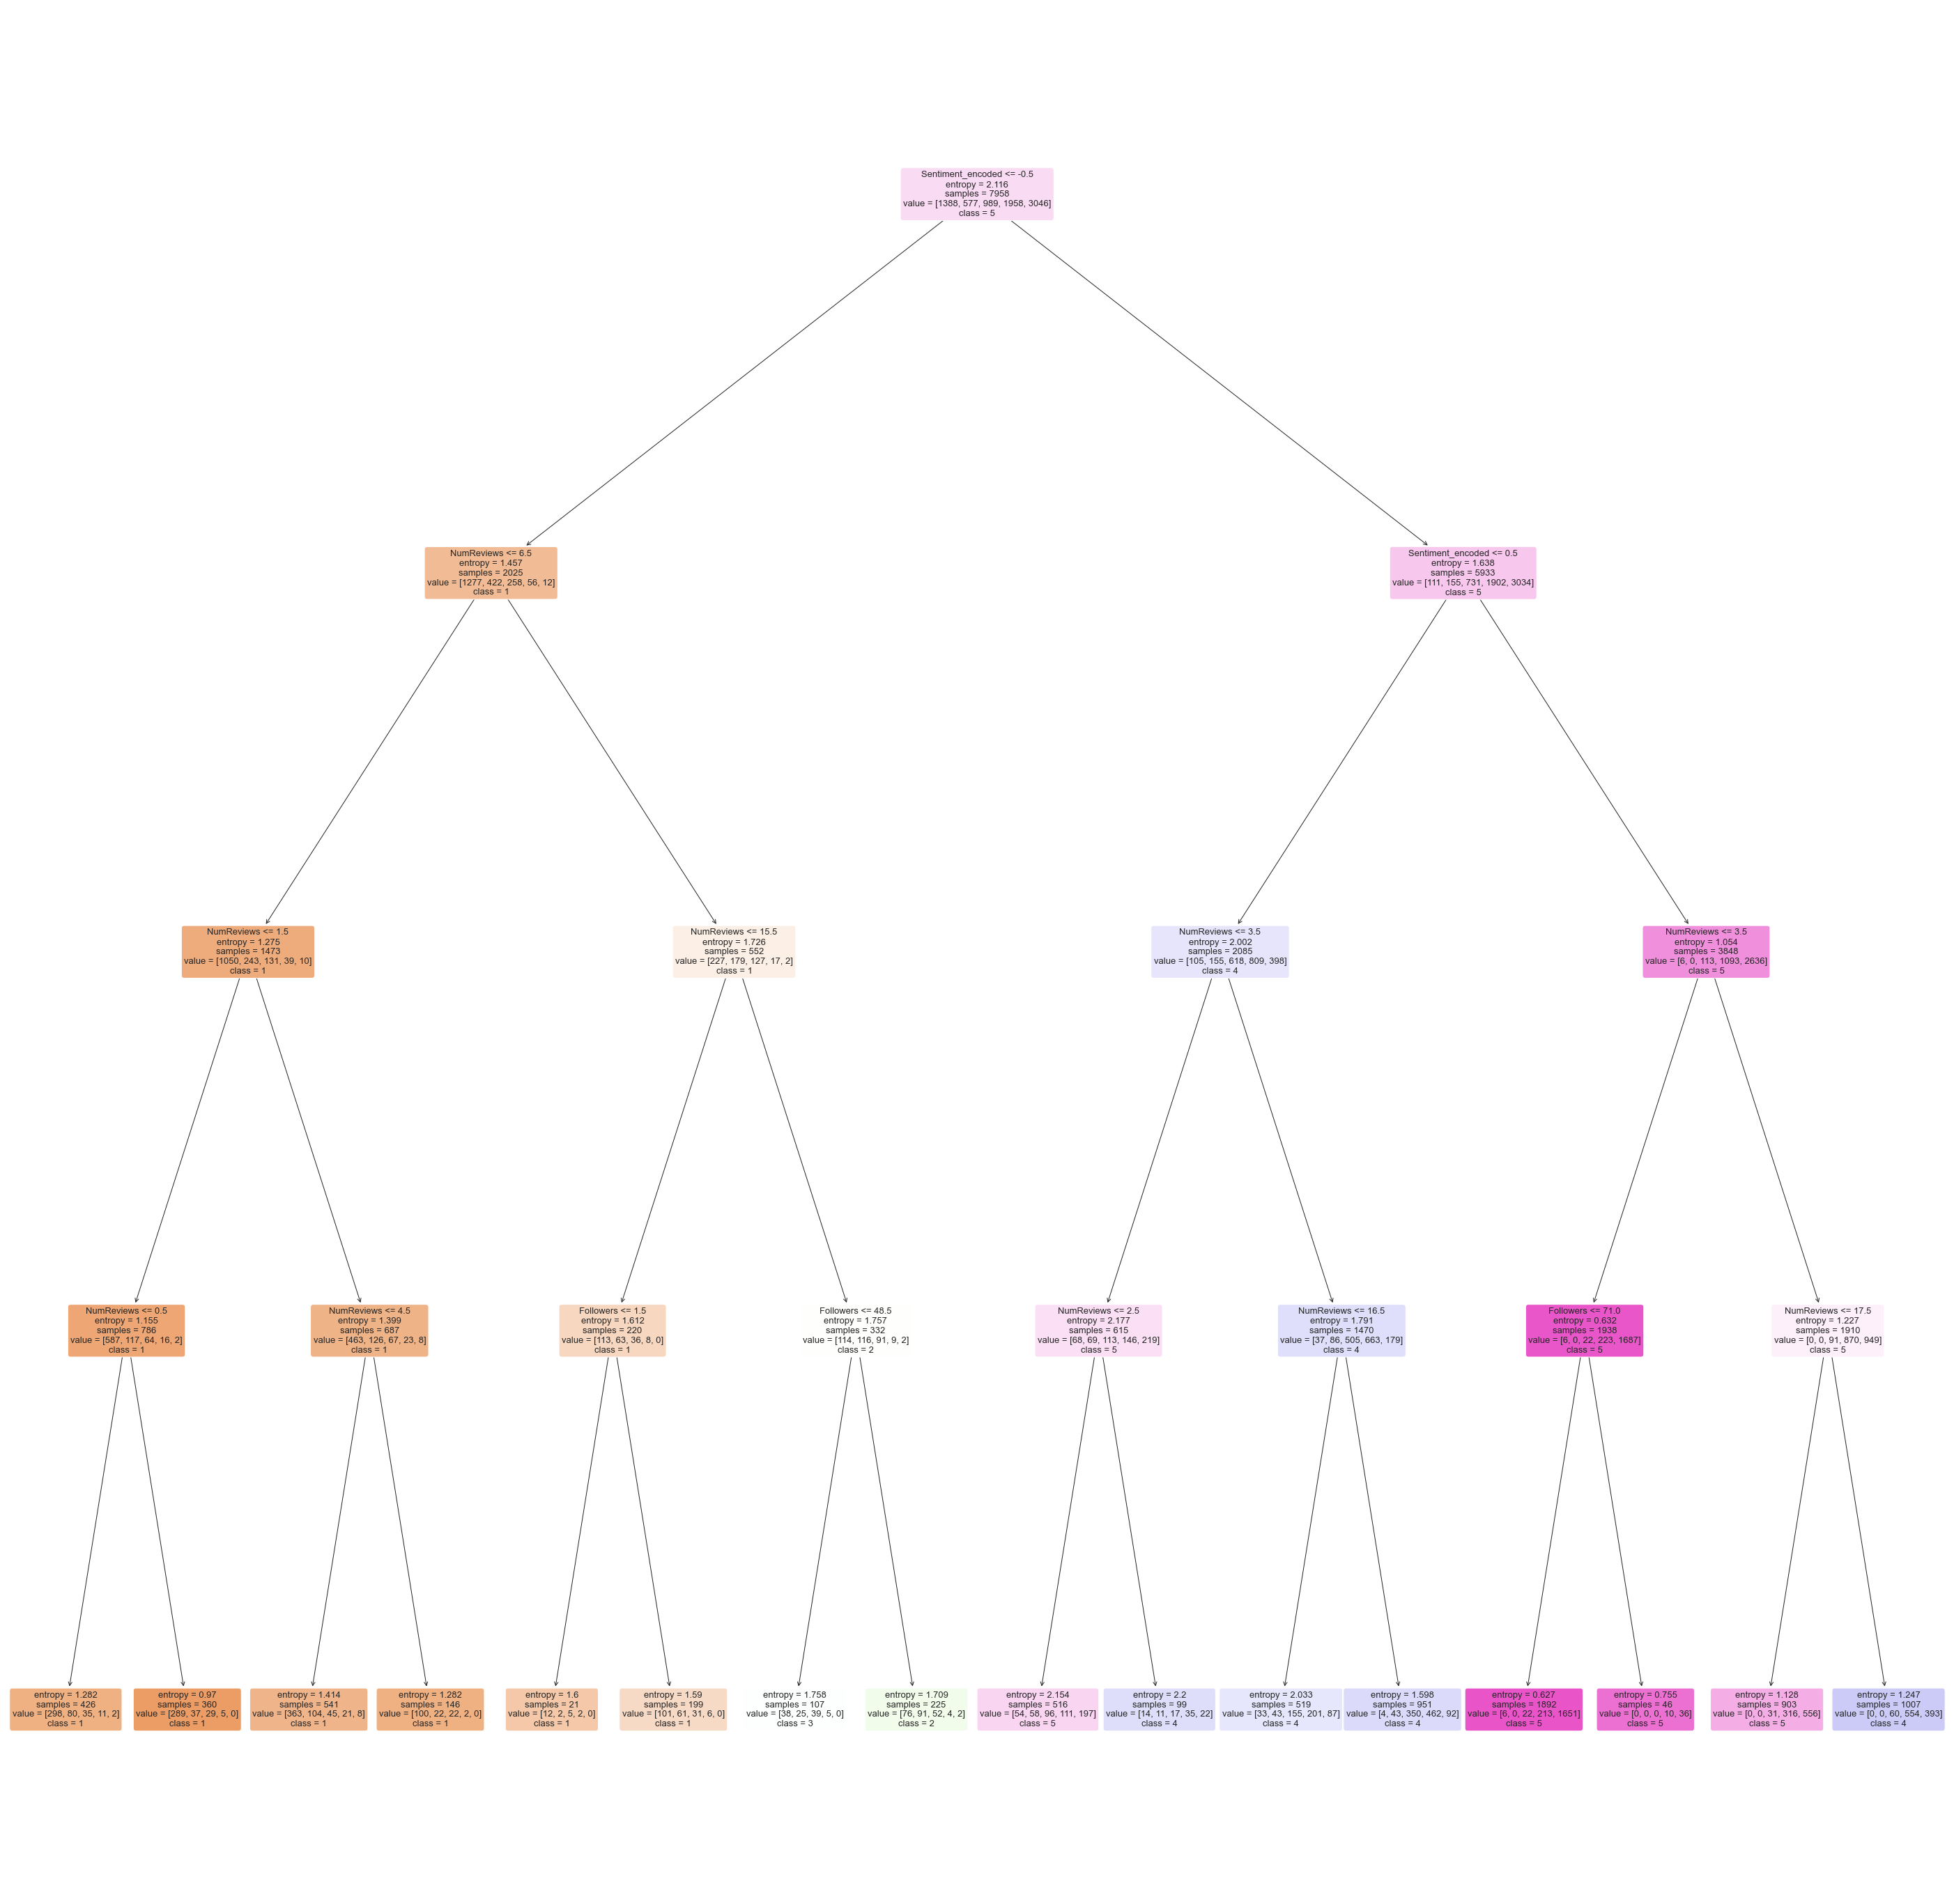

In [28]:
# Pintamos el árbol
plt.figure(figsize=(50,50))
plot_tree(dt, max_depth=4, fontsize=13, filled=True, feature_names=X.columns, class_names=classes.astype('str'), rounded=True)
plt.savefig("./graphs/tree-class-nores.png", bbox_inches='tight', dpi=200)
plt.show()

Veamos cómo clasifica el árbol generado: 

- Comienza realizando la primera bifurcación en función de `Sentiment_enconded`. En la rama izquierda encontraremos aquellas reviews que han sido clasificadas como negativas y en la derecha tanto las positivas como las neutras. 

- Observamos que la primera bifurcación realizada tiene buena pinta, pues tras separar una sóla vez se acumulan en torno a 1600 ejemplos combinando los Ratings 1 y 2 y ni siquiera 300 del resto. Además, en todas las hojas de la rama izquierda se predice un rating <= 2 a excepción de una, en la que se predice un 3, lo cual no resulta contradictorio (pues pueden existir reviews negativas de 3 estrellas) y además, tan solo tenemos 116 ejemplos clasificados en esta hoja. Observamos que en esta rama después se pregunta por `NumReviews` y en última instancia por `NumFollowers` (pues como veremos en la siguiente celda este es el orden de relevancia de las variables) pero que estas preguntas no resultan muy provechosas dado que no se llegan a clasificaciones que se puedan considerar bien fundamentadas. 

- En cuanto a la rama de la derecha, como ya hemos visto encontramos las reviews clasificadas como neutrales o positivas y por eso, lo más lógico es volver a preguntar por `Sentiment_encoded` para diferenciar ambos tipos de reviews, que es exactamente la decisión que se toma en el árbol presentado. En el hijo izquierdo nos quedamos con las reviews neutrales y casi en todos los casos predecimos valor de 4 y no de 5 para el campo rating, lo cual concuerda con el hecho de ser más neutral que positiva (aunque intuitivamente neutrales podrían ser las del 3 y no el 4), y en el hijo derecho, donde están las reviews positivas, casi siempre predecimos 5, lo cual tiene también mucho sentido. Observamos de nuevo que las preguntas sobre las otras dos variables no parecen para nada relevantes. 

- El punto débil de este árbol reside en la capacidad para clasificar la clase 3. A priori, este sería una puntuación de lo más natural para las reviews neutras pero no se predice este valor para ninguna de ellas, es más, todos los 3 que se predicen (que son realmente pocos), son para reviews negativas. Como hemos comentado esto no debe preocuparnos en exceso al ser el 3 un valor intermedio en el rango de clasificación. 



Feature: 0, Score: 0.84875
Feature: 1, Score: 0.00284
Feature: 2, Score: 0.14841


<AxesSubplot:>

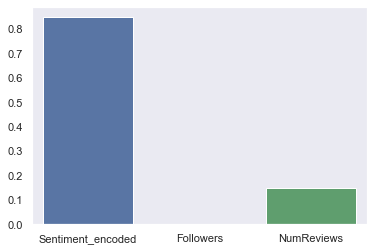

In [29]:
importance = dt.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
	
sns.barplot(x=X.columns,y=importance)

Efectivamente, como ya habíamos comentado, en este gráfico se aprecia que prácticamente todas las ratings se predicen en función de la variable `Sentiment_encoded` y que tanto `NumReviews` como `Followers` aportan realmente poco a la predicción (la tercera se podría incluso decir que no aporta nada). Este hecho explica y justifica los resultados de evaluación obtenidos y ratifica el hecho de que nos encontremos satisfechos con el árbol de decisión entrenado. 

La siguiente gráfica muestra la Predicción de `Rating` (en el eje Z) frente a las variables de entrada `Sentiment`, `NumReviews` y `Followers`. Nota: La gráfica anterior interactiva mostraba el valor real, no el predicho.

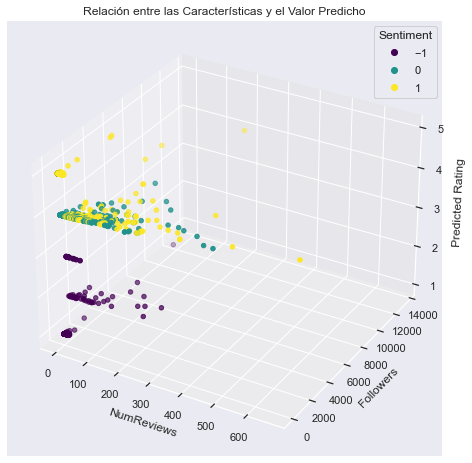

In [30]:
# Realiza predicciones con el árbol de decisión en los datos filtrados
predicted_ratings = dt.predict(X_test)

# Aumentar la resolución: definir un paso más pequeño
step = 1  # Reducir el paso en los ejes X, Y y Z

# Crear un rango de valores para los ejes X, Y y Z con un paso más pequeño
x_range = np.arange(min(X_test['NumReviews']), max(X_test['NumReviews']), step)
y_range = np.arange(min(X_test['Followers']), max(X_test['Followers']), step)
z_range = np.arange(1, 5, step)

# Crear una malla de coordenadas 3D
x, y, z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Crear un gráfico de dispersión 3D con alta resolución
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Puntos de datos
x = X_test['NumReviews']
y = X_test['Followers']
z = predicted_ratings
c = X_test['Sentiment_encoded']  # Colores basados en los sentiment

# Modificar las marcas y el espaciado del eje Z
custom_z_ticks = [1, 2, 3, 4, 5]  # Valores deseados en el eje Z
ax.set_zticks(custom_z_ticks)

# Gráfico de dispersión
scatter = ax.scatter(x, y, z, c=c, cmap='viridis')

# Configuración de los ejes
ax.set_xlabel('NumReviews')
ax.set_ylabel('Followers')
ax.set_zlabel('Predicted Rating')

# Crear una leyenda para representar los valores
legend = ax.legend(*scatter.legend_elements(), title='Sentiment')
ax.add_artist(legend)

plt.title('Relación entre las Características y el Valor Predicho')
plt.show()


Parece ser que nuestro árbol predice fuertemente hacia el 4 y el 5, más que hacia los otros valores. Las reviews que eran `Positive` o `Neutral` están clasificadas en torno al 4 y al 5. Las que eran `Negative` reciben valores en el 1, 2 y 3. Esto puede deberse al oversampling, lo que introduce la siguiente sección.

<a id='3-3'></a>
### 3.3. Entrenamiento y evaluación con oversampling

Utilizamos el algoritmo SMOTE de la librería imblearn para hacer 'oversampling'. Utilizamos la estrategia 'not majority' para que SMOTE haga resample de todas las clases salvo la mayoritaria, que en este caso es la del 5.

In [31]:
# Crea una instancia de SMOTE para equilibrar las clases
smote = SMOTE(sampling_strategy='not majority', random_state=RANDOM_STATE)

# Aplica SMOTE al conjunto de entrenamiento
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Muestra el balance de clases después de aplicar SMOTE
print("Clase 1 después de SMOTE:", sum(y_resampled == 1))
print("Clase 2 después de SMOTE:", sum(y_resampled == 2))
print("Clase 3 después de SMOTE:", sum(y_resampled == 3))
print("Clase 4 después de SMOTE:", sum(y_resampled == 4))
print("Clase 5 después de SMOTE:", sum(y_resampled == 5))

Clase 1 después de SMOTE: 3046
Clase 2 después de SMOTE: 3046
Clase 3 después de SMOTE: 3046
Clase 4 después de SMOTE: 3046
Clase 5 después de SMOTE: 3046


A continuación, repetimos todo el proceso realizado para el árbol, ahora con el oversampling de los datos. Elegimos el mejor `max_depth` según las gráficas y entrenamos y dibujamos el árbol y la importancia de sus variables.

In [32]:
train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 8)
for md in max_depths: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, X_resampled.values, y_resampled.values, scoring='accuracy', cv=10, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
train_accuracy, test_accuracy

([0.3804990151017728,
  0.5221930400525279,
  0.5376522944480921,
  0.5478879404683739,
  0.5543736776829357,
  0.5610418034580872,
  0.5702925512511856],
 [0.38049901510177275,
  0.5221930400525279,
  0.5325673013788575,
  0.5427445830597505,
  0.5472094550229809,
  0.5510177281680894,
  0.5521996060407091])

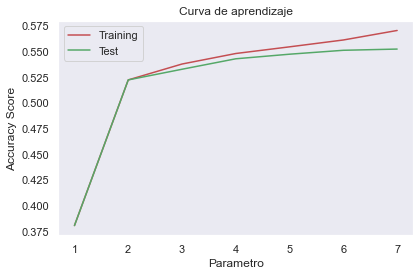

In [33]:
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()  

Probamos con `max_depth = 4`

In [34]:
# Escribimos las métricas que queremos evaluar
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']

# Construimos el clasificador
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=2, random_state=RANDOM_STATE)

# Calculamos las métricas utilizando validación cruzada
scores = cross_validate(clf, X_resampled, y_resampled, scoring=scoring_metrics, cv=10, return_train_score=False)

# Mostrar las métricas agregadas
print('Precisión ponderada media: ',np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media: ',np.mean(scores['test_recall_weighted']))
print('F1 ponderado media: ',np.mean(scores['test_f1_weighted']))

Precisión ponderada media:  0.5497433459151665
Exhaustividad ponderada media:  0.5427445830597505
F1 ponderado media:  0.5143910441437777


Accuracy: 57.49%
Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.71      0.72       355
           2       0.24      0.33      0.28       126
           3       0.33      0.62      0.43       249
           4       0.49      0.28      0.36       484
           5       0.77      0.72      0.75       776

    accuracy                           0.57      1990
   macro avg       0.51      0.53      0.51      1990
weighted avg       0.61      0.57      0.58      1990

Confusion matrix, without normalization
[[251  84  17   0   3]
 [ 52  42  31   0   1]
 [ 30  32 154  17  16]
 [  8  12 183 136 145]
 [  3   8  80 124 561]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

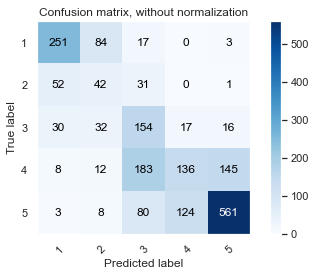

In [56]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=RANDOM_STATE)
dt.fit(X_resampled, y_resampled)

y_pred = dt.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_resampled_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Classification Report
report = classification_report(y_test, y_resampled_pred)
print("Classification Report:\n", report)

# Confusion Matrix
classes = np.sort(y_test.unique())
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(y_test,y_resampled_pred,classes)

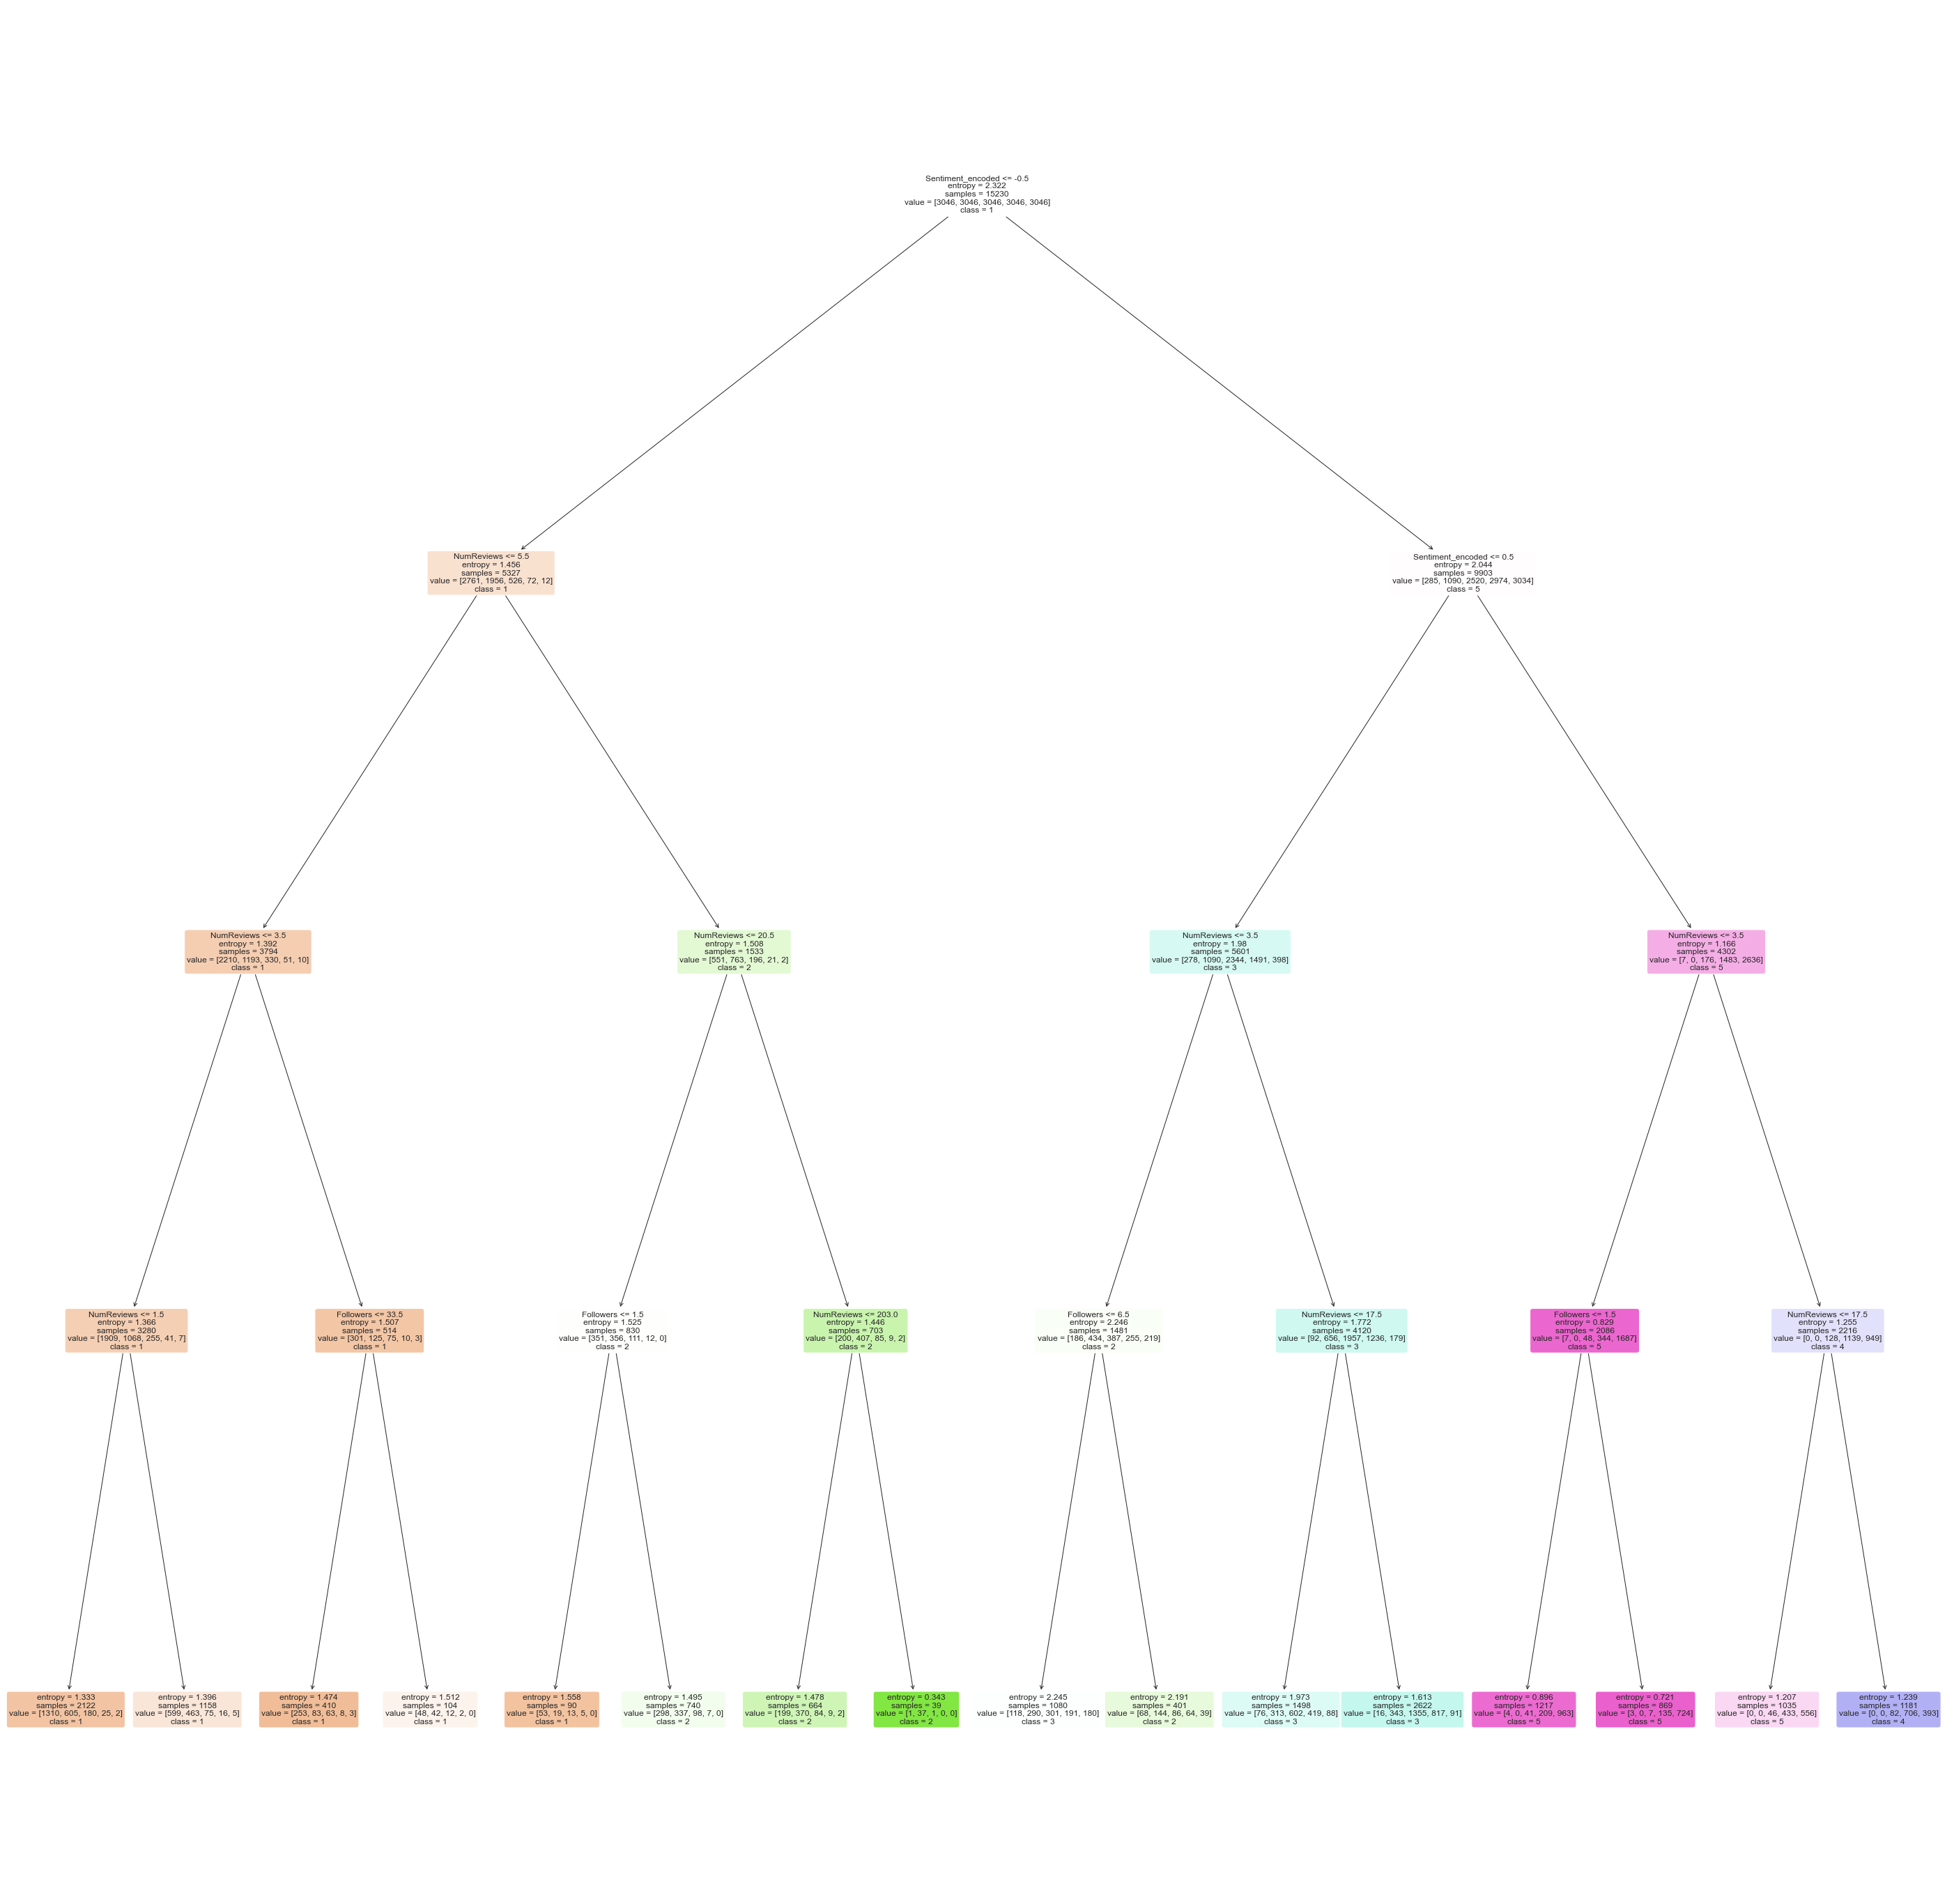

In [57]:
# Pintamos el árbol
plt.figure(figsize=(50,50))
plot_tree(dt,max_depth=4, fontsize=12, filled=True, feature_names=X_resampled.columns, class_names=classes.astype('str'), rounded=True)
plt.savefig("./graphs/tree-class-res.png", bbox_inches='tight', dpi=200)
plt.show()

Feature: 0, Score: 0.88488
Feature: 1, Score: 0.00528
Feature: 2, Score: 0.10985


<AxesSubplot:>

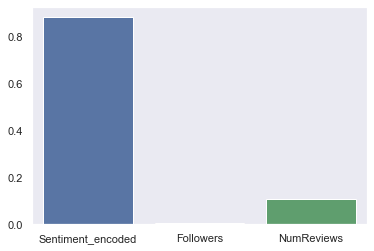

In [37]:
importance = dt.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
	
sns.barplot(x=X.columns, y=importance)

Finalmente, no hemos observado ninguna mejora en el modelo al utilizar oversampling. Es más, la precisión ha disminuido y, aunque ahora se acierta más veces la clase 3, por otro lado también se confunde con la 4 y la 5 e incluso algunos unos y doses se confunden con cuatros y cincos. Debe ser que al crear nuevos datos sintéticos nuestras variables no sirvan para diferenciar las clases lo suficientemente bien y por tanto al tener más tengamos más confusión.

<a id='3-4'></a>
### 3.4. Regresión

Se plantea también el problema como uno de regresión porque consideramos que predicciones no enteras de `Rating` pueden tener cierta intepretación. Predecir un valor decimal puede verse como una mediad de "confianza" hacia las clases enteras entre las que se encuentra. Por ejemplo, si el árbol predice un valor de 4.3 se puede pensar que la review tiene más posibilidades de ser un 4 que un 5.

A continuación, probamos también el árbol como regresor. Probamos las diferentes profundidades y elegimos una. 

In [38]:
max_depths = range(1,8)
cv_scores = []
for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
    scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))

print(cv_scores)

best_score = np.argmin(cv_scores)
best_max_depth = max_depths[np.argmin(cv_scores)]
print(f'Best max_depth: {best_max_depth}')

[0.8061667451399532, 0.6072695134666461, 0.59021790723027, 0.587691342035561, 0.5945834257129453, 0.6007404902819391, 0.6068940285807821]
Best max_depth: 4


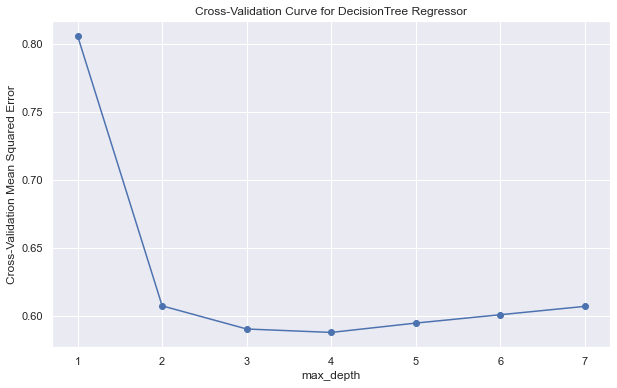

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, cv_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Cross-Validation Mean Squared Error')
plt.title('Cross-Validation Curve for DecisionTree Regressor')
plt.grid(True)
plt.show()

A la vista de la gráfica y la celda anterior, entrenamos el árbol con profundidad máxima 4

In [59]:
regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=4, random_state=RANDOM_STATE)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.5819143777926258
R-squared: 0.7374355247330332


Como comentábamos, el hecho de predecir valores reales en este problema siempre generará fallo en las métricas dado que los valores verdaderos son enteros. Por ejemplo, si para una hoja el árbol predice 4.3 para un ejemplo con `Rating` 4 o 5, el error cuadrático medio que se acumula será de 0.3^2 en caso de que fuera 4 o 0.7^2 = 0.49 en el caso de que fuera 5. Esto se traduce en que el valor númerico del error siempre va a ser elevado. Sin embargo, consideramos que este error también es "interpretable" en el sentido de que un 4.3 podría indicar que el árbol considera que la review está más cerca de un 4 que de un 5, aunque pudiéndose equivocar.

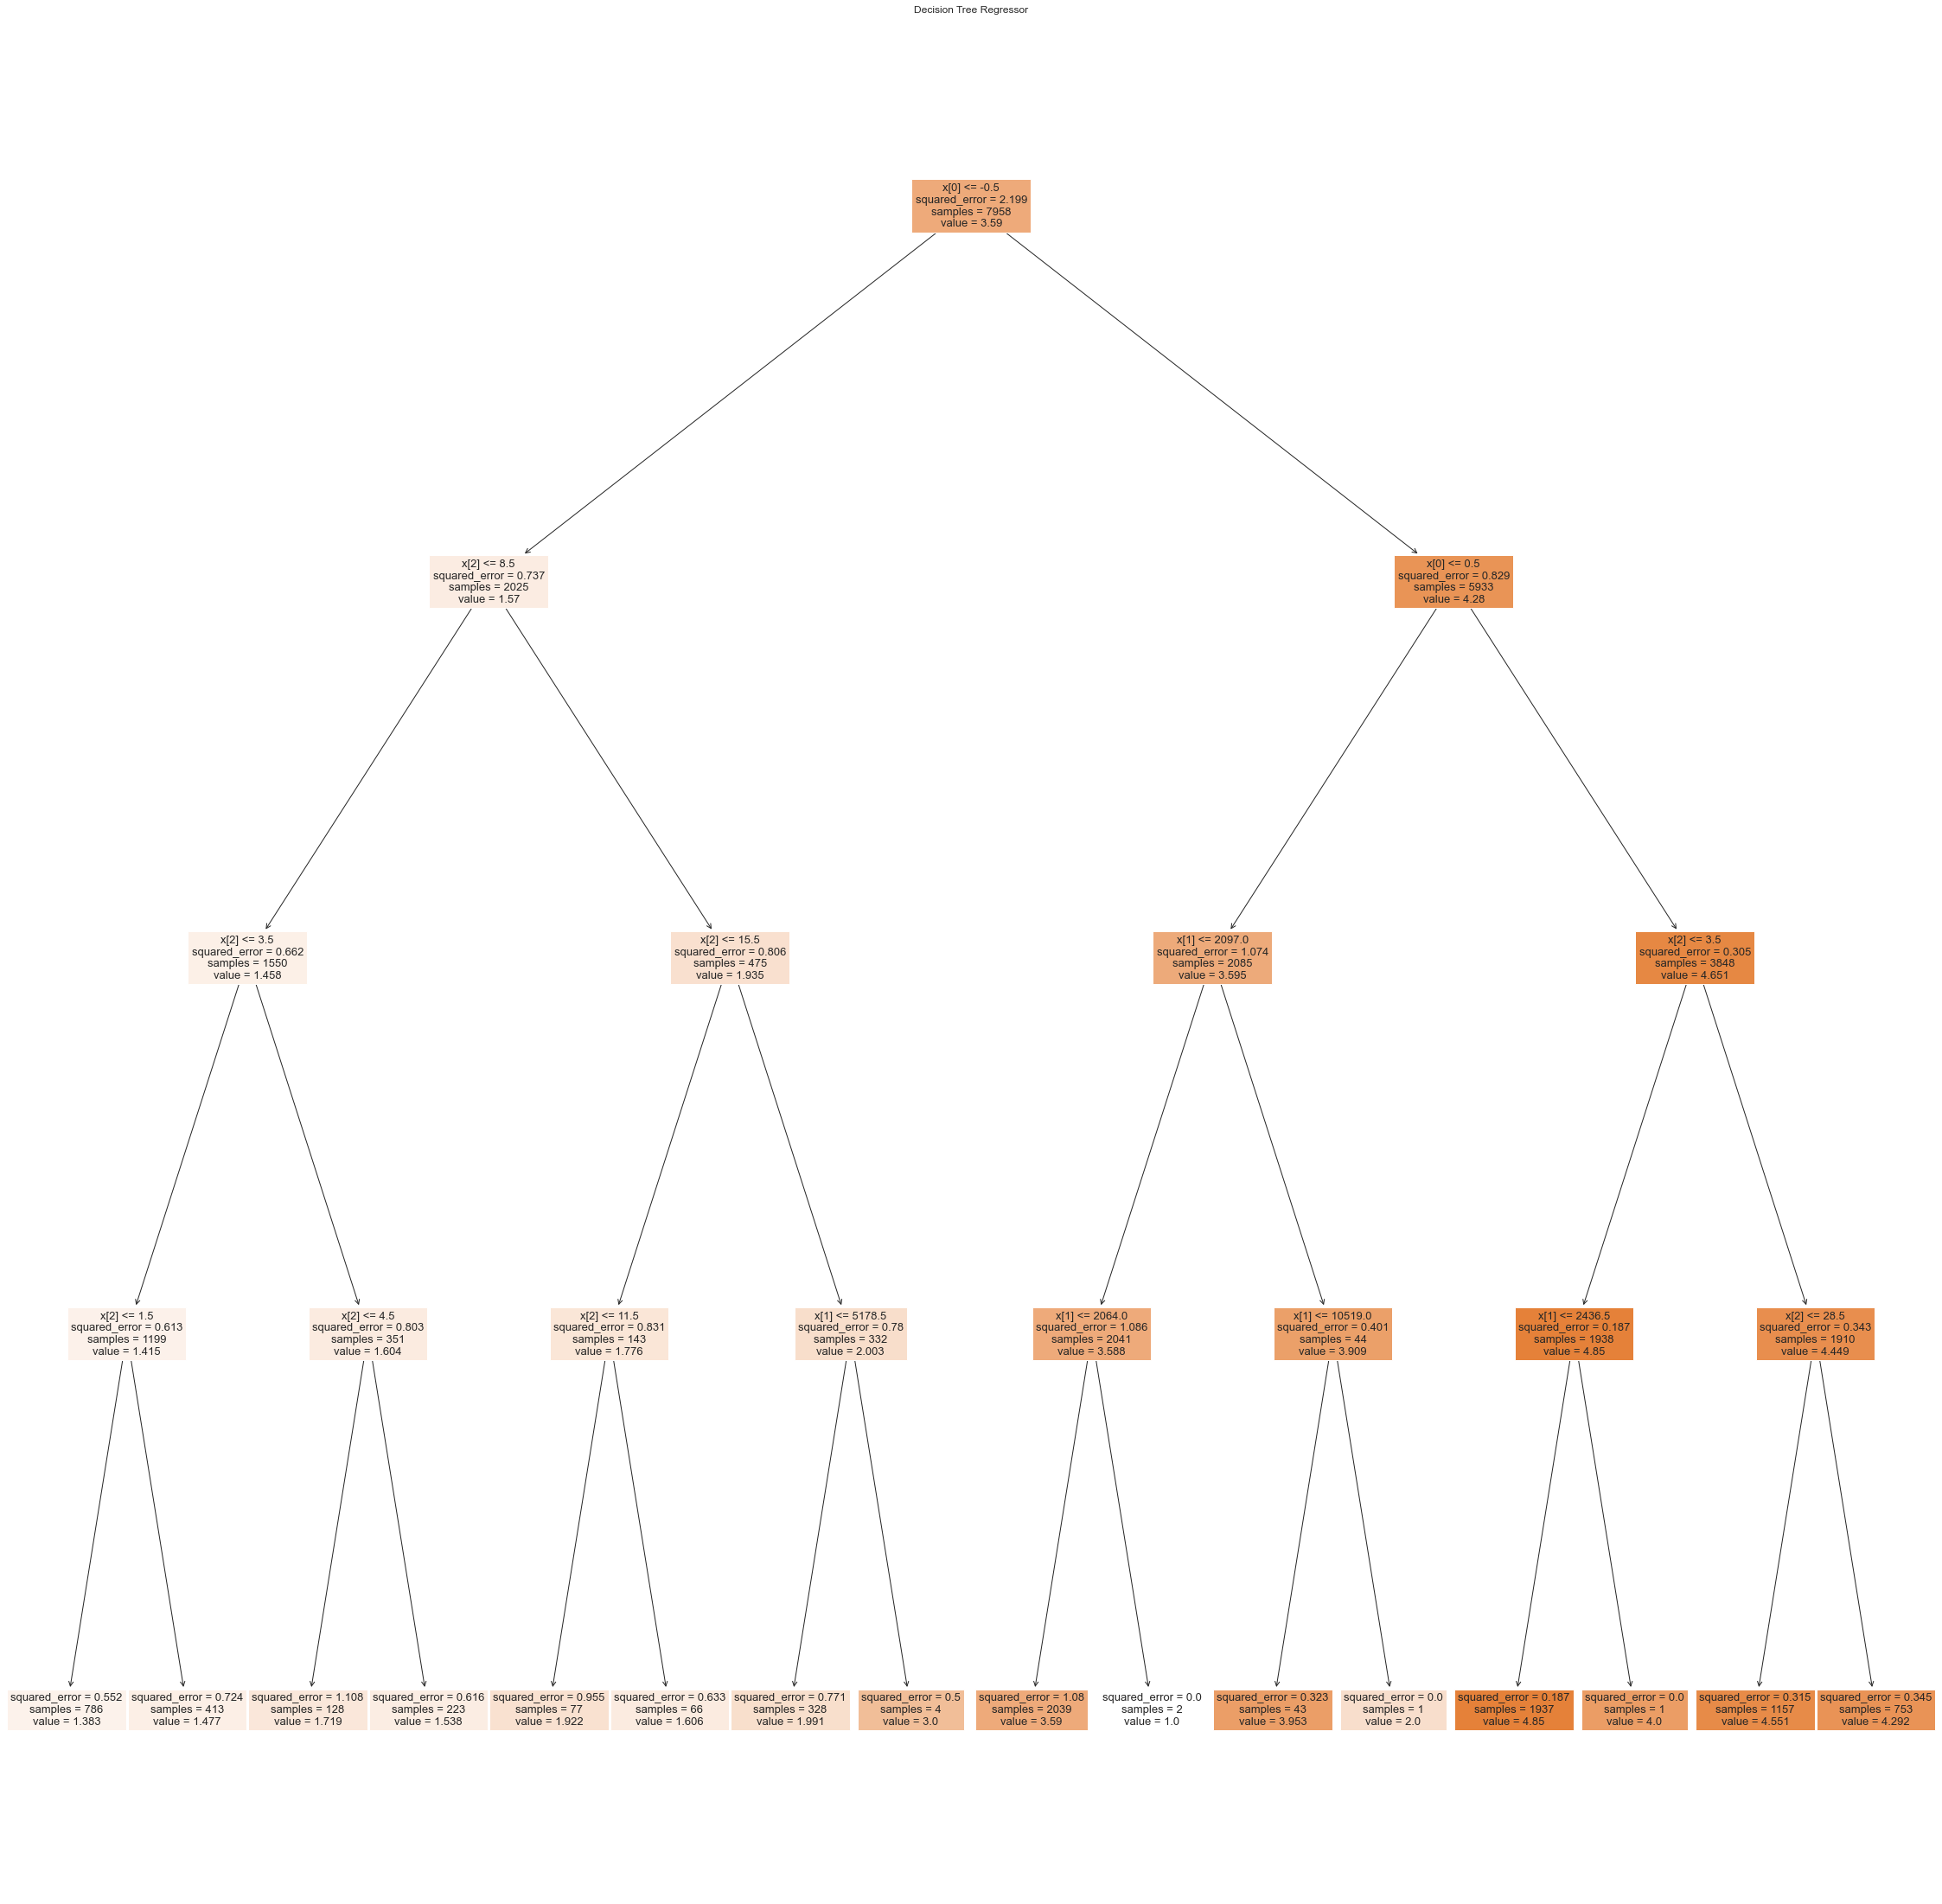

In [60]:
plt.figure(figsize=(40, 40))
plot_tree(regressor, fontsize=13, max_depth=4, filled=True)
plt.title('Decision Tree Regressor')
plt.savefig("./graphs/tree-reg.png", bbox_inches='tight', dpi=200)
plt.show()

<a id='4'></a>
## 4. Conclusiones

Después del estudio realizado, hemos llegado a la conclusión de que no se trata de un problema fácil, en el sentido de que no es un problema en el cual se vayan a obtener buenas métricas. Las variables de las que se dispone son poco informativas y, aunque `Sentiment` es la única que permite diferenciar mejor, esta no sirve para afinar el `Rating` concreto de una review. Al final, saber si una review es "buena", "mala" o "normal" no te permite deducir una puntuación concreta para la misma. Además, la variable `Followers` ha sido irrelevante en todos los árboles y la variable `NumReviews` no ha sido de gran importancia, posiblemente porque en el mundo real no haya mucha correlación entre el número de reviews escritas por un usuario y el `Rating` que este le da a un establecimiento concreto.

Hemos considerado el problema como uno de clasificación, pensando que el usuario da "estrellas" enteras al establecimiento. La poca información con la que contamos es la causa de los pobres resultados, ya que la precisión no distingue el fallo entre las diferentes clases, esto es, "cuenta igual" confundir un cuatro con un cinco que un cinco con un uno. Desde este punto de vista, si le damos al modelo un poco de margen, podemos entender que no se comporta tan mal, ya que lo que más confunde es cuatros con cincos y unos con doses. Esto es exactamente lo que decimos, puede diferenciar reviews buenas de reviews malas sin afinar mucho en cuánto de buenas/malas son, lo cual es consecuencia directa de la distribución natural de los datos y de la coherencia del Sentiment Analysis que se ha llevado a cabo con Mistral.

Este problema se mantiene si lo planteamos también como una regresión, ya que al no predecir valores enteros siempre acumularemos error. Aunque el planteamiento de regresión sí permite al modelo "afinar" un poco más su predicción en cuanto al `Rating`, de nuevo las variables con las que contamos no son suficientes para hacer un buen trabajo. Pensamos que en el caso en el cual tuviéramos mejores variables, el modelo de regresión se asemejaría al de clasificación, prediciendo valores cercanos a los números enteros del uno al cinco.

Además las técnicas que hemos probado para mejorar el rendimiento del árbol (overesampling y GridSearchCV, ver Anexo) no han sido satisfactorias, por lo que el modelo a utilizar sería el primero: el árbol de clasificación sin oversampling que puede verse en la gráfica `/graphs/tree-class-nores.png`.

<a id='5'></a>
## 5. Anexo. Pruebas con GridSearchCV

Probamos diferentes combinaciones de `max_depth`, `min_samples_leaf` y los posibles criterios a minimizar (`gini` o `entropy`) para intentar conseguir alguna mejora en los resultados del árbol.

<a id='5-1'></a>
### 5.1. GridSearchCV para el árbol de clasificación

In [45]:
X = df[['Sentiment_encoded', 'Followers', 'NumReviews']]
y = df['Rating']
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

In [46]:
dt = DecisionTreeClassifier()

param_dict = {"max_depth": range(2, 8),
              "min_samples_leaf": range(1, 10),
              "criterion": ["gini", "entropy"],
              "random_state": [RANDOM_STATE]}

dt_cv =GridSearchCV(estimator = dt, param_grid=param_dict, cv=10, scoring='accuracy')
dt_cv.fit(X,y)
    
print(dt_cv.best_params_)
print(dt_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'random_state': 123}
0.6179168478205919


Accuracy: 61.11%
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.85      0.76       355
           2       0.24      0.10      0.14       126
           3       0.25      0.02      0.03       249
           4       0.46      0.59      0.52       484
           5       0.70      0.79      0.75       776

    accuracy                           0.61      1990
   macro avg       0.47      0.47      0.44      1990
weighted avg       0.56      0.61      0.56      1990

Confusion matrix, without normalization
[[302  20   8   9  16]
 [ 75  12   4  20  15]
 [ 43  14   4 145  43]
 [ 13   3   0 284 184]
 [  5   0   0 157 614]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

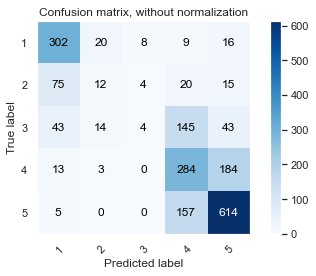

In [47]:
best_dt = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_leaf=2, random_state=RANDOM_STATE)

best_dt.fit(X_train, y_train)

y_pred = best_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

classes = np.sort(y_test.unique())
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(y_test,y_pred,classes)

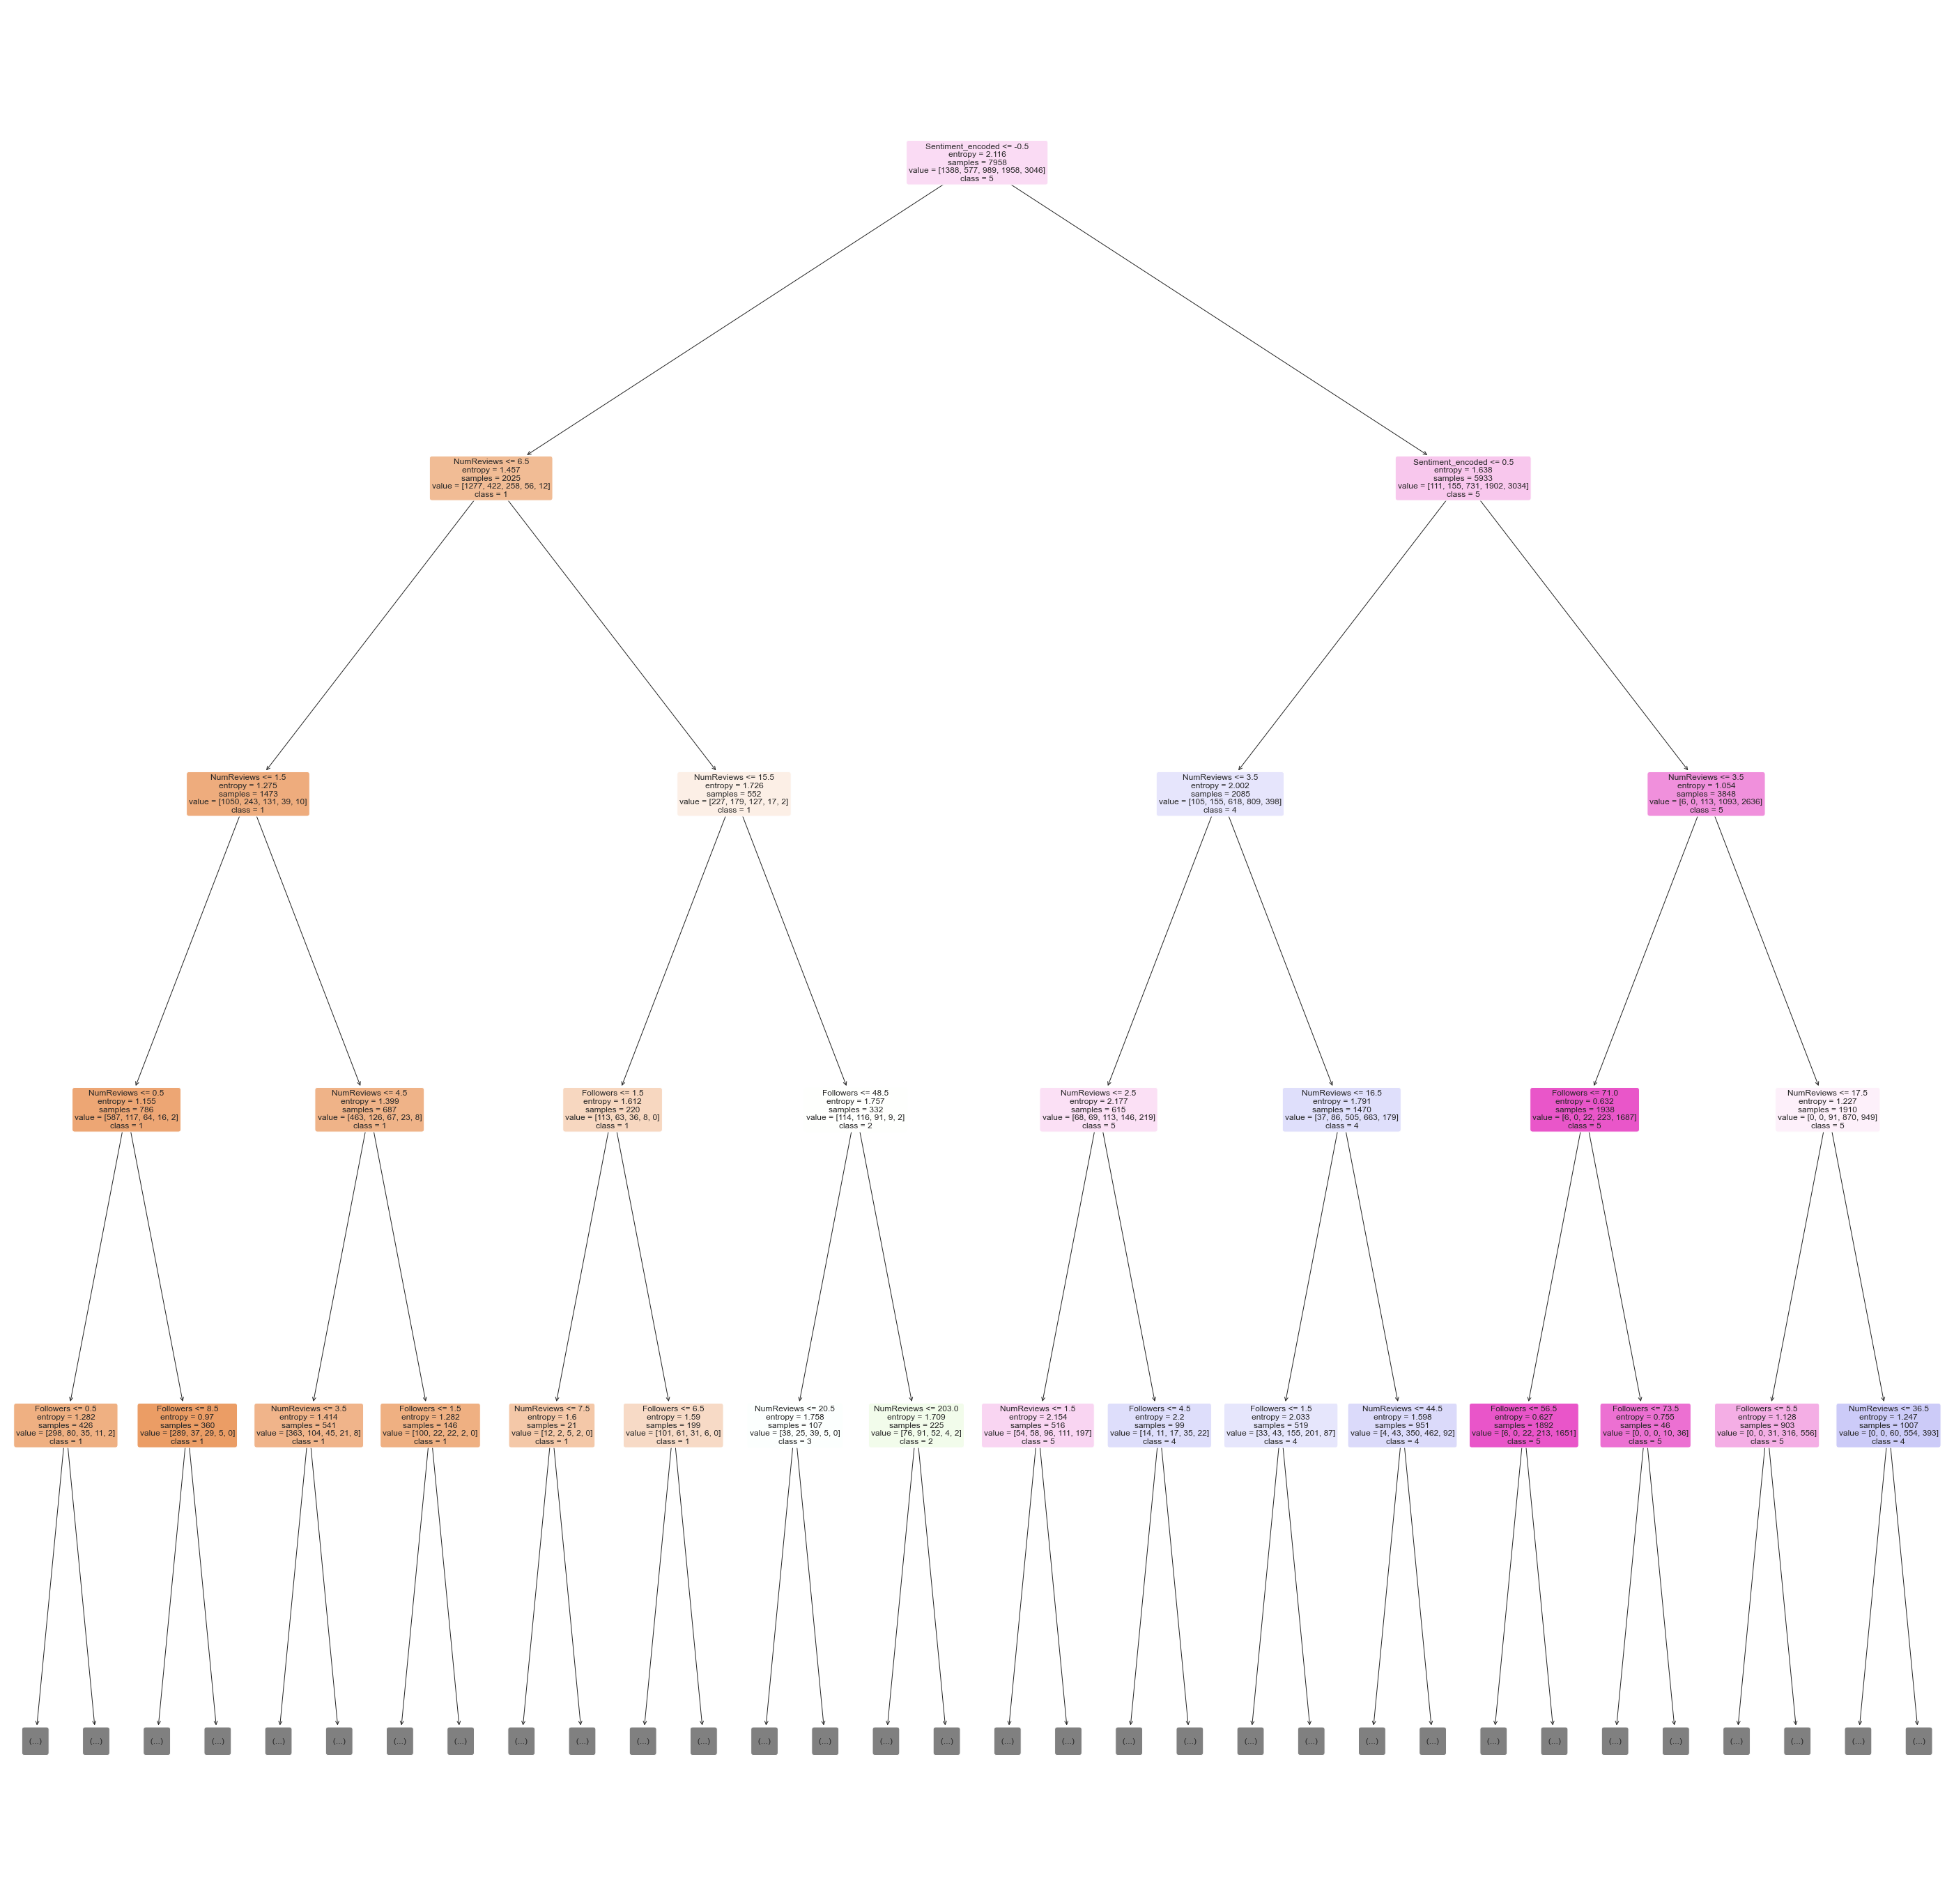

In [48]:
# Pintamos el árbol
plt.figure(figsize=(50,50))
plot_tree(best_dt, max_depth=4, fontsize=12, filled=True, feature_names=X.columns, class_names=classes.astype('str'), rounded=True)
plt.savefig("./graphs/tree-class-gridsearch.png", bbox_inches='tight', dpi=200)
plt.show()

Feature: 0, Score: 0.81569
Feature: 1, Score: 0.02627
Feature: 2, Score: 0.15805


<AxesSubplot:>

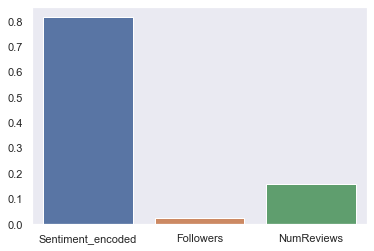

In [49]:
importance = best_dt.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
	
sns.barplot(x=X.columns, y=importance)

<a id='5-2'></a>
### 5.2. GridSearchCV para el árbol de regresión

In [15]:
X = df[['Sentiment_encoded', 'Followers', 'NumReviews']]
y = df['Rating']
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

La siguiente celda tarda unos minutillos.

In [21]:
param_grid = {
    'criterion': ['squared_error', 'poisson', 'friedman_mse'],
    'max_depth': range(1, 8),
    'min_samples_leaf': range(1, 10),
    'random_state': [RANDOM_STATE]
}

regressor = DecisionTreeRegressor()

grid_search = GridSearchCV(regressor, param_grid, cv=10)

grid_search.fit(X, y)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 3, 'random_state': 123}


In [24]:
best_regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=4, min_samples_leaf=3, random_state=RANDOM_STATE)

best_regressor.fit(X_train, y_train)

y_pred_best = best_regressor.predict(X_test)

# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

classes = np.sort(y_test.unique())

# Print the results for the Best Model
print(f'MSE for Best Model: {mse_best}')
print(f'R-squared for Best Model: {r2_best}')

MSE for Best Model: 0.5817243492111158
R-squared for Best Model: 0.7375212671664461


De nuevo, comprobamos que la mejora no es especialmente significativa.

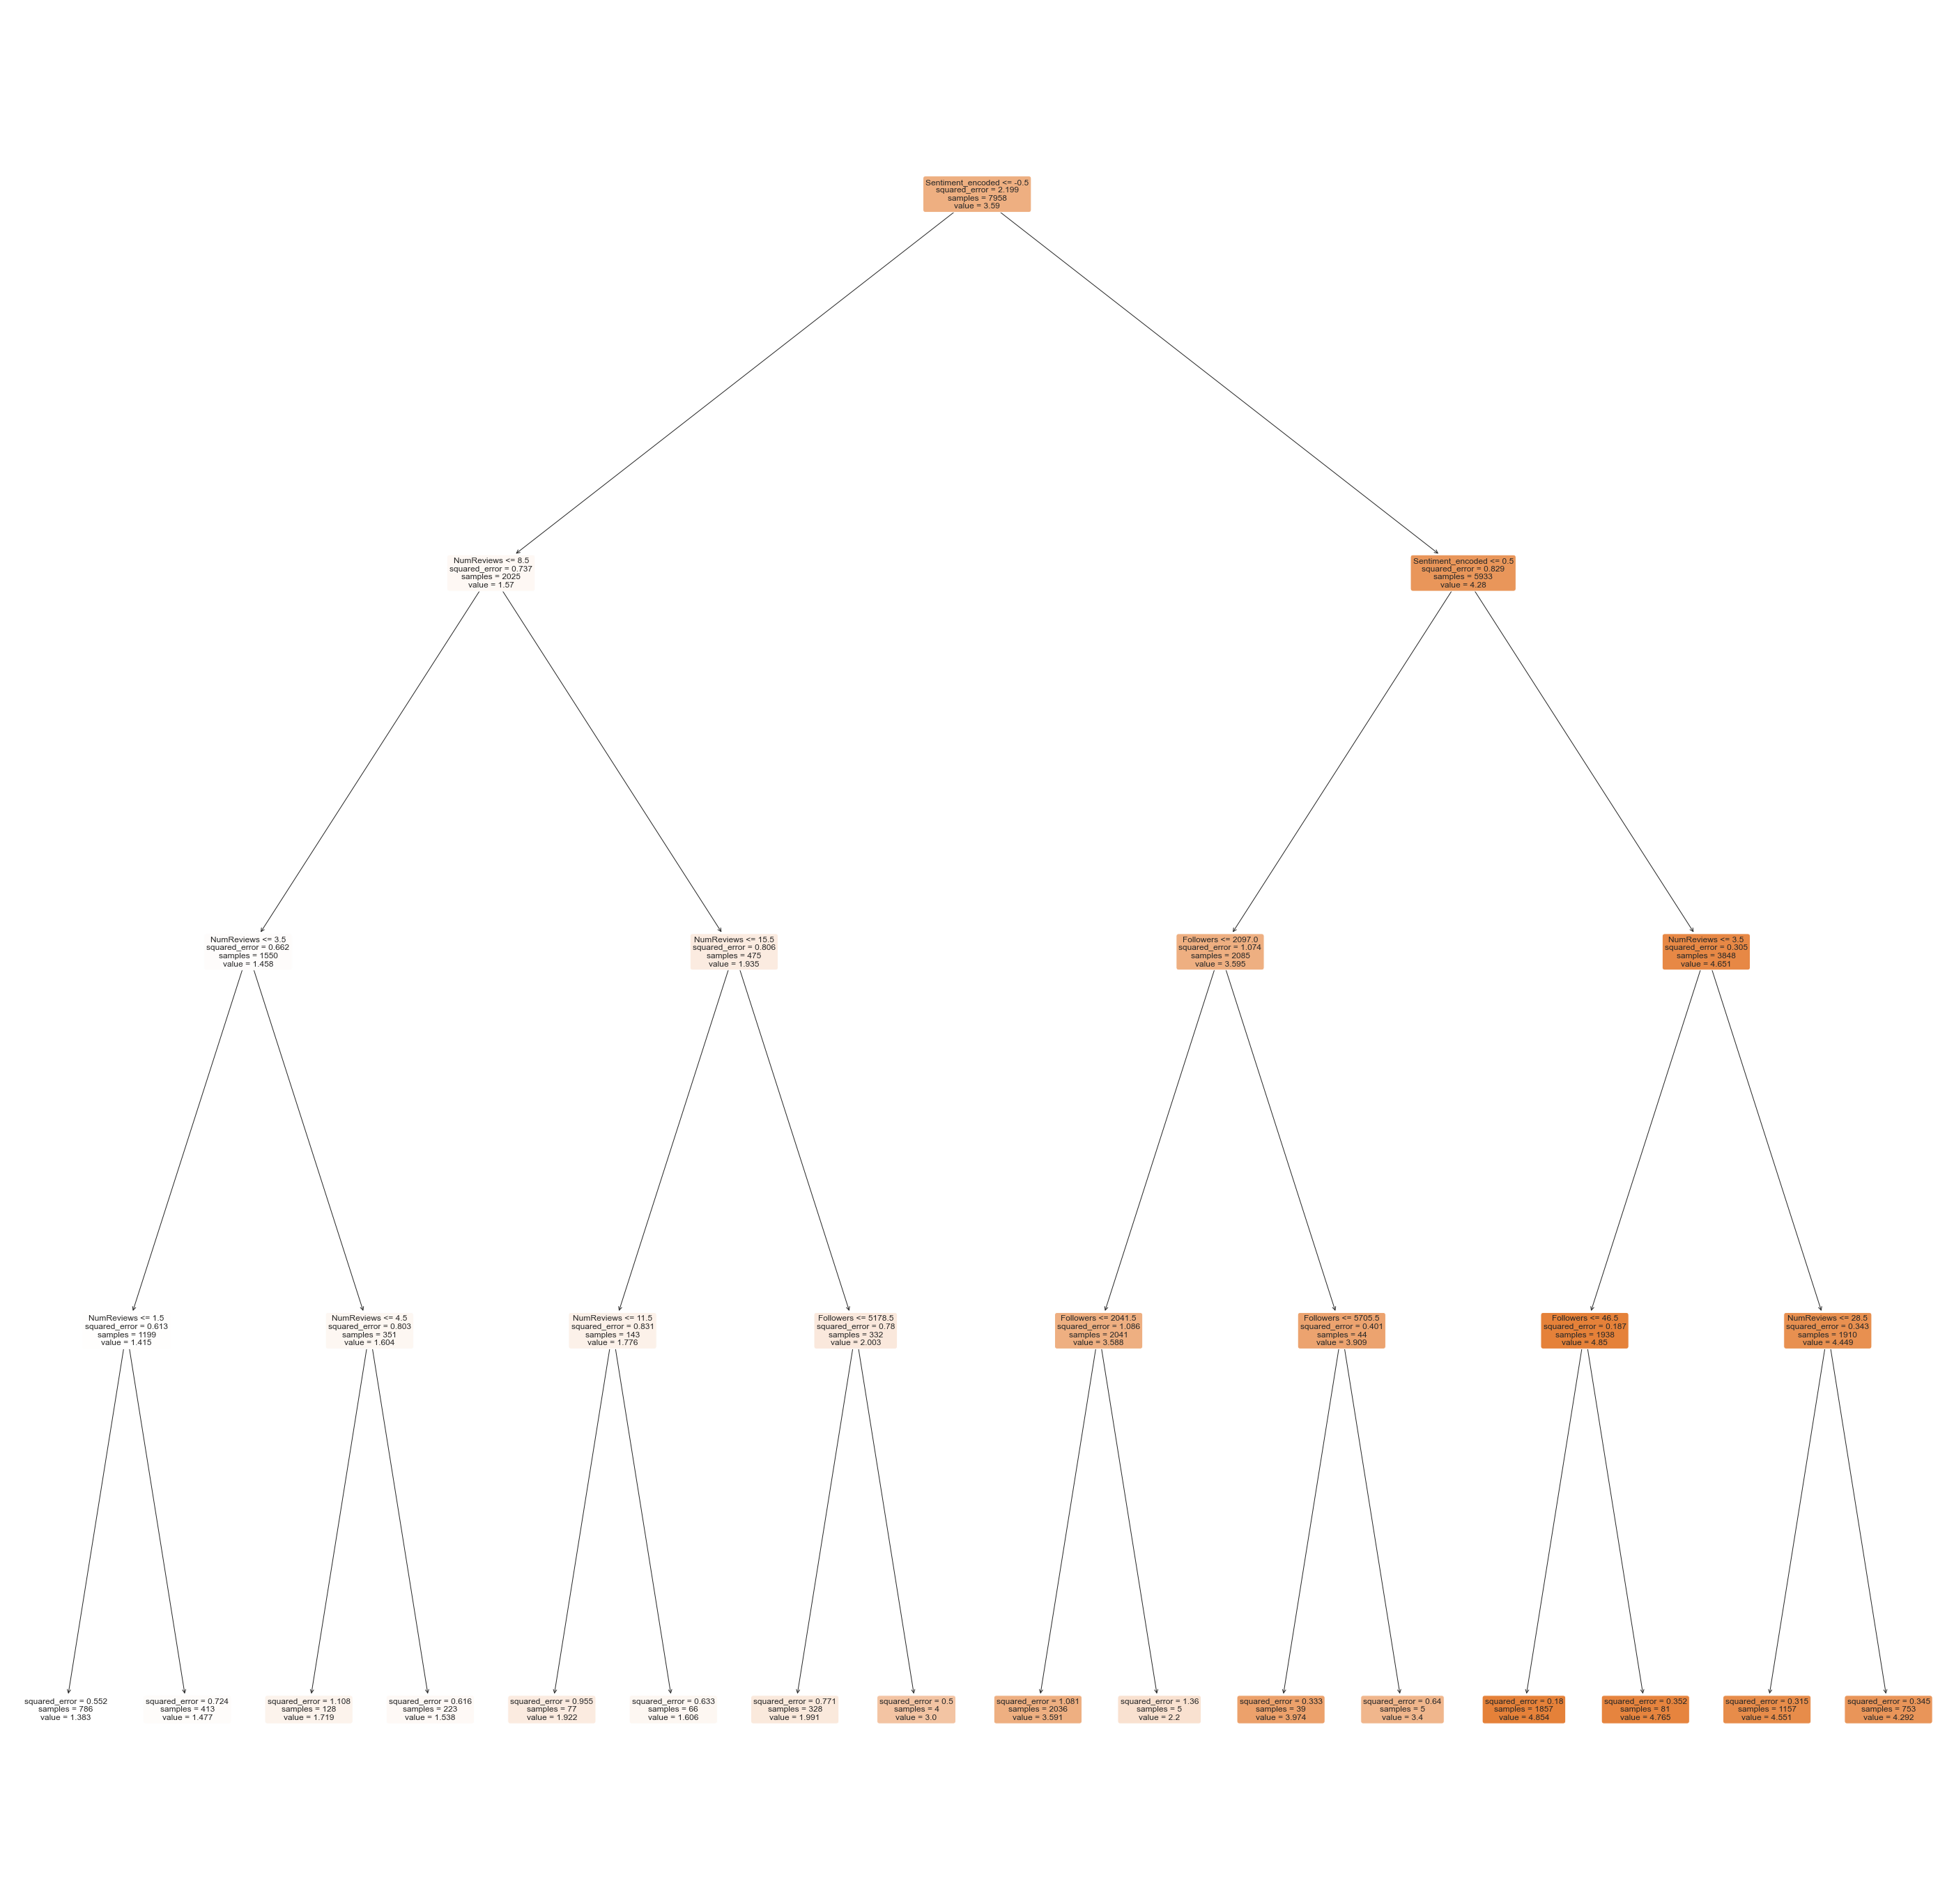

In [25]:
# Pintamos el árbol
plt.figure(figsize=(50,50))
plot_tree(best_regressor, max_depth=4, fontsize=12, filled=True, feature_names=X.columns, class_names=classes.astype('str'), rounded=True)
plt.savefig("./graphs/tree-reg-gridsearch.png", bbox_inches='tight', dpi=200)
plt.show()

Feature: 0, Score: 0.97588
Feature: 1, Score: 0.00156
Feature: 2, Score: 0.02255


<AxesSubplot:>

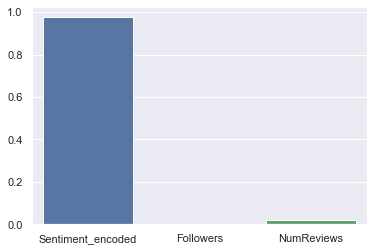

In [26]:
importance = best_regressor.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
	
sns.barplot(x=X.columns, y=importance)